# 分析健康人與病患的腸道菌相
##### 資料集取自 Gutmeta 資料庫  https://gutmeta.deepomics.org/

## 1. 分析資料中的各健康狀態所佔人數

In [267]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold

import warnings
warnings.filterwarnings('ignore')

In [23]:
# 讀取數據庫
# 原始csv中共20897筆資料

data = pd.read_csv('healthy_IBD_microbiome.csv')

# 將 None 轉換為 NaN
data = data.replace('None', pd.np.nan)

# 移除包含缺失值的行
data = data.dropna(axis=0)

In [24]:
data

,Sample name,disease,k__Archaea,k__Archaea|p__Euryarchaeota,k__Archaea|p__Euryarchaeota|c__Methanobacteria,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium|s__Methanobacterium_formicicum,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium|s__Methanobacterium_sp_MB1,...,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Tectiviridae,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Tectiviridae|g__Betatectivirus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Tectiviridae|g__Betatectivirus|s__Bacillus_virus_GIL16,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Phage_Gifsy_1,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Phage_Gifsy_2,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Salmonella_phage_Fels_1,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Streptococcus_pyogenes_phage_5005_2,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Streptococcus_pyogenes_phage_H10403
0,CA_C10001IS2006FE_t1M15,Health,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CA_C10001IS2009FE_t2M15,Health,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CA_C10001IS2012FE_t3M15,Health,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CA_C10002IS2023FE_t2M15,Health,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CA_C10002IS2026FE_t3M15,Health,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20892,T2D-098,"Diabetes Mellitus, Type 2",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20893,T2D-099,"Diabetes Mellitus, Type 2",4.940769,4.940769,4.940769,4.940769,4.940769,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20894,T2D-100,"Diabetes Mellitus, Type 2",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20895,T2D-101,"Diabetes Mellitus, Type 2",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# 顯示 'disease' 欄位中的不同數值的數量
print(data['disease'].nunique())

96


In [26]:
# 顯示 'disease' 欄位中96個不同的健康狀態
print(data['disease'].unique())

['Health' 'Colorectal Neoplasms' 'Irritable Bowel Syndrome'
 'Glucose Intolerance' 'Glucose Intolerance; Respiratory Tract Infections'
 'Respiratory Tract Infections' 'Diabetes Mellitus, Type 2'
 'Diabetes Mellitus, Type 2; Respiratory Tract Infections'
 'Neoplasm Metastasis' 'Adenoma'
 'Colorectal Neoplasms; Hypercholesterolemia' 'Adenoma; Hypertension'
 'Hypercholesterolemia' 'Adenoma; Hypercholesterolemia' 'Hypertension'
 'Colorectal Neoplasms; Hypertension' 'Hypertension; Neoplasm Metastasis'
 'Diabetes Mellitus, Type 2; Adenoma' 'Adenoma; Neoplasm Metastasis'
 'Colorectal Neoplasms; Hypercholesterolemia; Hypertension'
 'Adenoma; Hypercholesterolemia; Neoplasm Metastasis'
 'Colorectal Neoplasms; Neoplasm Metastasis'
 'Surgical Procedures, Operative' 'Polyps' 'Atherosclerosis'
 'Melanoma; Neoplasm Metastasis' 'Shiga-Toxigenic Escherichia coli'
 'Crohn Disease' 'Diabetes Mellitus, Type 1'
 'Irritable Bowel Syndrome; Rectal Fistula' 'Liver Cirrhosis; Hepatitis'
 'Ascites; Liver Cirrho

##### 資料集中的健康狀態:
| 英文名稱                                                | 中文名稱                                               |
|---------------------------------------------------------|--------------------------------------------------------|
| Health                                                  | 健康                                                   |
| Colorectal Neoplasms                                    | 大腸直腸癌                                             |
| Irritable Bowel Syndrome                                | 過敏性腸症候群                                           |
| Glucose Intolerance                                     | 葡萄糖耐受不良                                           |
| Glucose Intolerance; Respiratory Tract Infections        | 葡萄糖耐受不良; 呼吸道感染                                 |
| Respiratory Tract Infections                             | 呼吸道感染                                               |
| Diabetes Mellitus, Type 2                               | 2型糖尿病                                               |
| Diabetes Mellitus, Type 2; Respiratory Tract Infections  | 2型糖尿病; 呼吸道感染                                     |
| Neoplasm Metastasis                                     | 轉移性腫瘤                                               |
| Adenoma                                                 | 腺瘤                                                   |
| Colorectal Neoplasms; Hypercholesterolemia               | 大腸直腸癌; 高膽固醇血症                                   |
| Adenoma; Hypertension                                   | 腺瘤; 高血壓                                             |
| Hypercholesterolemia                                    | 高膽固醇血症                                             |
| Adenoma; Hypercholesterolemia                           | 腺瘤; 高膽固醇血症                                         |
| Hypertension                                            | 高血壓                                                 |
| Colorectal Neoplasms; Hypertension                       | 大腸直腸癌; 高血壓                                         |
| Hypertension; Neoplasm Metastasis                        | 高血壓; 轉移性腫瘤                                         |
| Diabetes Mellitus, Type 2; Adenoma                      | 2型糖尿病; 腺瘤                                           |
| Adenoma; Neoplasm Metastasis                            | 腺瘤; 轉移性腫瘤                                           |
| Colorectal Neoplasms; Hypercholesterolemia; Hypertension | 大腸直腸癌; 高膽固醇血症; 高血壓                             |
| Adenoma; Hypercholesterolemia; Neoplasm Metastasis       | 腺瘤; 高膽固醇血症; 轉移性腫瘤                               |
| Colorectal Neoplasms; Neoplasm Metastasis                | 大腸直腸癌; 轉移性腫瘤                                     |
| Surgical Procedures, Operative                          | 外科手術
  |
| Polyps                                                  | 息肉
  |
| Atherosclerosis                                         | 動脈粥樣硬化
  |
| Melanoma; Neoplasm Metastasis                           | 黑色素瘤；轉移性腫瘤
  |
| Shiga-Toxigenic Escherichia coli                        | 沙門氏菌毒素製造腸桿菌

In [27]:
# 按照疾病狀態分組，統計每個狀態的數量
disease_count = data.groupby('disease')['disease'].count().reset_index(name='count')

# 輸出表格
display(disease_count)

,disease,count
0,Adenoma,159
1,Adenoma; Fatty Liver,12
2,Adenoma; Fatty Liver; Hypertension,14
3,Adenoma; Hypercholesterolemia,4
4,Adenoma; Hypercholesterolemia; Neoplasm Metast...,1
...,...,...
91,"Skin Diseases, Infectious",2
92,"Spondylitis, Ankylosing",97
93,Stomatitis,2
94,"Surgical Procedures, Operative",40


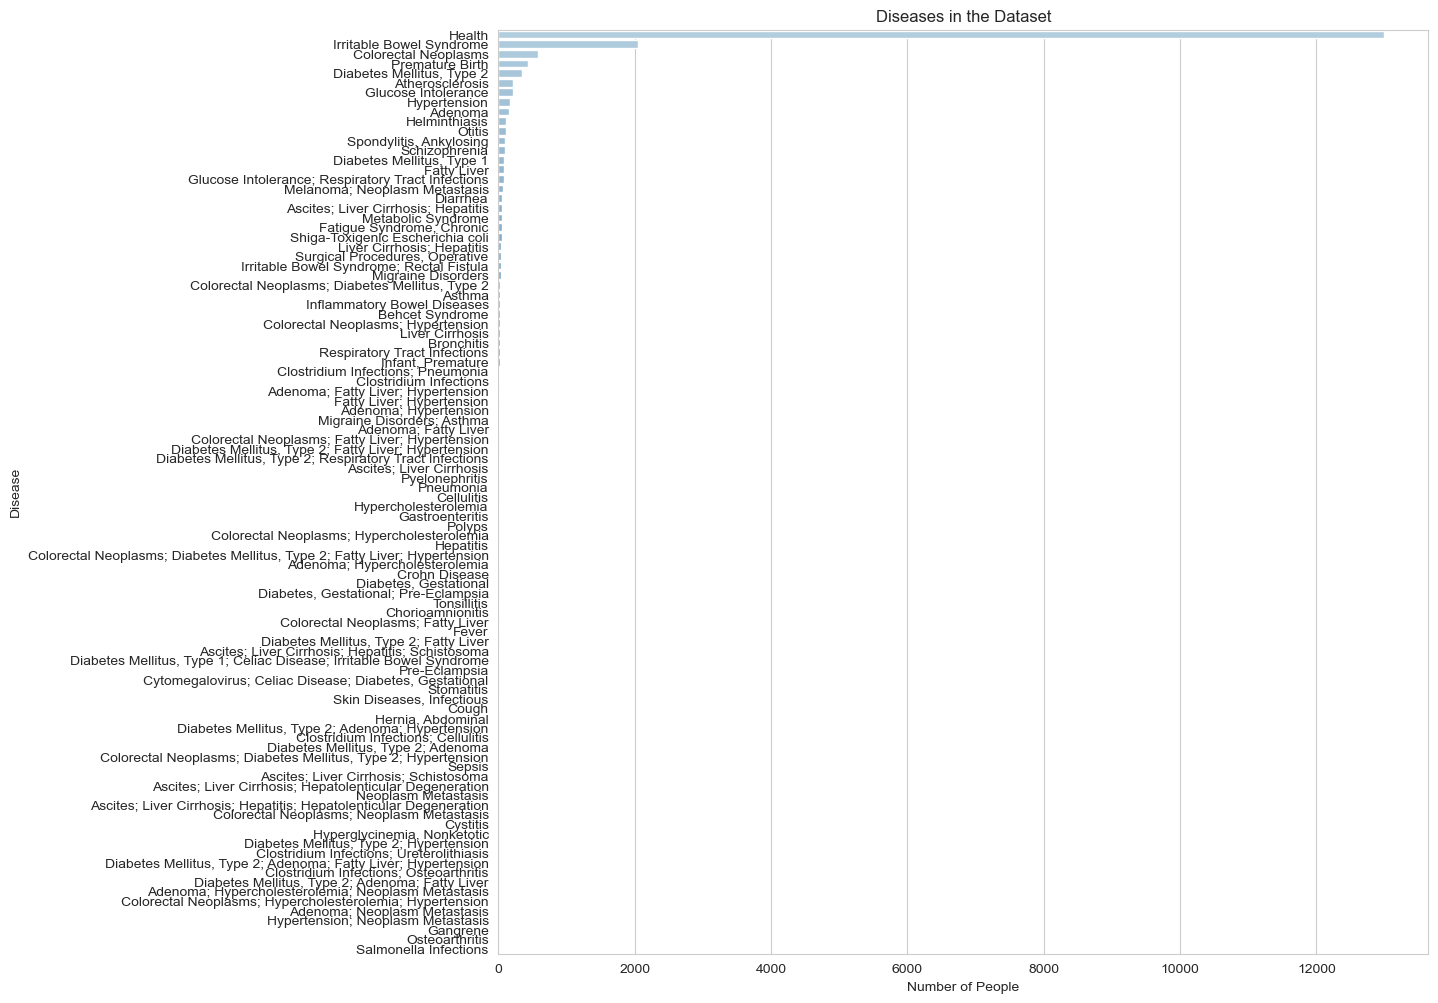

In [28]:
# 統計每個疾病的數量
disease_counts = data['disease'].value_counts()

# 繪製柱狀圖
sns.set_style("whitegrid")
plt.figure(figsize=(12,12))
sns.barplot(x=disease_counts.values, y=disease_counts.index, palette="Blues_d")
plt.xlabel('Number of People')
plt.ylabel('Disease')
plt.title('Diseases in the Dataset')
plt.show()

## 2. 因為資料集中健康人數和各種疾病病患樣本數相差太多, 所以僅分析健康人與資料中病患人數相對較多的過敏性腸症候群 (Irritable Bowel Syndrome, IBD) 的菌相差異

In [29]:
# 從 data dataframe 中選擇 “健康”和“過敏性腸症候群”樣本
selected_data = data[data['disease'].isin(['Health', 'Irritable Bowel Syndrome'])]

# 顯示選擇的數據中疾病類型的計數
print(selected_data['disease'].value_counts())

Health                      12992
Irritable Bowel Syndrome     2048
Name: disease, dtype: int64


In [30]:
# 將健康的人和病人分別存為兩個 DataFrame
healthy = data[data['disease'] == 'Health']
healthy

,Sample name,disease,k__Archaea,k__Archaea|p__Euryarchaeota,k__Archaea|p__Euryarchaeota|c__Methanobacteria,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium|s__Methanobacterium_formicicum,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium|s__Methanobacterium_sp_MB1,...,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Tectiviridae,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Tectiviridae|g__Betatectivirus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Tectiviridae|g__Betatectivirus|s__Bacillus_virus_GIL16,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Phage_Gifsy_1,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Phage_Gifsy_2,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Salmonella_phage_Fels_1,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Streptococcus_pyogenes_phage_5005_2,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Streptococcus_pyogenes_phage_H10403
0,CA_C10001IS2006FE_t1M15,Health,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CA_C10001IS2009FE_t2M15,Health,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CA_C10001IS2012FE_t3M15,Health,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CA_C10002IS2023FE_t2M15,Health,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CA_C10002IS2026FE_t3M15,Health,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20594,SAMN11977916,Health,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20855,T2D-027,Health,0.138503,0.138503,0.133303,0.133303,0.133303,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20858,T2D-032,Health,0.007849,0.007849,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20860,T2D-037,Health,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
IBD = data[data['disease'] == 'Irritable Bowel Syndrome']
IBD

,Sample name,disease,k__Archaea,k__Archaea|p__Euryarchaeota,k__Archaea|p__Euryarchaeota|c__Methanobacteria,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium|s__Methanobacterium_formicicum,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium|s__Methanobacterium_sp_MB1,...,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Tectiviridae,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Tectiviridae|g__Betatectivirus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Tectiviridae|g__Betatectivirus|s__Bacillus_virus_GIL16,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Phage_Gifsy_1,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Phage_Gifsy_2,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Salmonella_phage_Fels_1,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Streptococcus_pyogenes_phage_5005_2,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Streptococcus_pyogenes_phage_H10403
328,CSM5FZ3N_P,Irritable Bowel Syndrome,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
329,CSM5FZ3R_P,Irritable Bowel Syndrome,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
330,CSM5FZ3T_P,Irritable Bowel Syndrome,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
331,CSM5FZ3V_P,Irritable Bowel Syndrome,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
332,CSM5FZ3X_P,Irritable Bowel Syndrome,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17495,SAMN07200400,Irritable Bowel Syndrome,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17496,SAMN07200401,Irritable Bowel Syndrome,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17497,SAMN07200402,Irritable Bowel Syndrome,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17498,SAMN07200403,Irritable Bowel Syndrome,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
# 將健康跟IBD病患的菌株轉成array
healthy_bacteria = healthy.values[:, 2:]
healthy_bacteria

array([[0.0, 0.0, 0.0, ..., 0, 0, 0],
       [0.0, 0.0, 0.0, ..., 0, 0, 0],
       [0.0, 0.0, 0.0, ..., 0, 0, 0],
       ...,
       ['0.007849', '0.007849', '0', ..., '0', '0', '0'],
       ['0', '0', '0', ..., '0', '0', '0'],
       ['0', '0', '0', ..., '0', '0', '0']], dtype=object)

In [142]:
IBD_bacteria = IBD.values[:, 2:]
IBD_bacteria

array([[0.0, 0.0, 0.0, ..., 0, 0, 0],
       [0.0, 0.0, 0.0, ..., 0, 0, 0],
       [0.0, 0.0, 0.0, ..., 0, 0, 0],
       ...,
       [0.0, 0.0, 0.0, ..., 0, 0, 0],
       [0.0, 0.0, 0.0, ..., 0, 0, 0],
       [0.0, 0.0, 0.0, ..., 0, 0, 0]], dtype=object)

In [143]:
# 將數組轉換為 float 類型
healthy_bacteria = healthy_bacteria.astype(float)
IBD_bacteria = IBD_bacteria.astype(float)

In [248]:
# 將 bacteria strains 的名稱簡化
original_strain_names = ['k__Archaea','k__Archaea|p__Euryarchaeota','k__Archaea|p__Euryarchaeota|c__Methanobacteria','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium|s__Methanobacterium_formicicum','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium|s__Methanobacterium_sp_MB1','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_arboriphilus','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_oralis','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_ruminantium','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_sp_87_7','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_sp_AbM4','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_thaueri','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_woesei','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera|s__Methanosphaera_cuniculi','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera|s__Methanosphaera_sp_SHI1033','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera|s__Methanosphaera_sp_rholeuAM74','k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera|s__Methanosphaera_stadtmanae','k__Archaea|p__Euryarchaeota|c__Thermococci','k__Archaea|p__Euryarchaeota|c__Thermococci|o__Thermococcales','k__Archaea|p__Euryarchaeota|c__Thermococci|o__Thermococcales|f__Thermococcaceae','k__Archaea|p__Euryarchaeota|c__Thermococci|o__Thermococcales|f__Thermococcaceae|g__Pyrococcus','k__Archaea|p__Euryarchaeota|c__Thermococci|o__Thermococcales|f__Thermococcaceae|g__Pyrococcus|s__Pyrococcus_yayanosii','k__Archaea|p__Euryarchaeota|c__Thermoplasmata','k__Archaea|p__Euryarchaeota|c__Thermoplasmata|o__Methanomassiliicoccales','k__Archaea|p__Euryarchaeota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Methanomassiliicoccaceae','k__Archaea|p__Euryarchaeota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Methanomassiliicoccaceae|g__Candidatus_Methanomethylophilus','k__Archaea|p__Euryarchaeota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Methanomassiliicoccaceae|g__Candidatus_Methanomethylophilus|s__Candidatus_Methanomethylophilus_sp_1R26','k__Archaea|p__Euryarchaeota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Methanomassiliicoccaceae|g__Methanomassiliicoccus','k__Archaea|p__Euryarchaeota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Methanomassiliicoccaceae|g__Methanomassiliicoccus|s__Candidatus_Methanomassiliicoccus_intestinalis','k__Archaea|p__Euryarchaeota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Methanomassiliicoccales_unclassified','k__Archaea|p__Euryarchaeota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Methanomassiliicoccales_unclassified|g__Methanomassiliicoccales_unclassified','k__Archaea|p__Euryarchaeota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Methanomassiliicoccales_unclassified|g__Methanomassiliicoccales_unclassified|s__Methanomassiliicoccales_archaeon_RumEn_M1','k__Bacteria','k__Bacteria|p__Actinobacteria','k__Bacteria|p__Actinobacteria|c__Actinobacteria','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_massiliense','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_sp_oral_taxon_183','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_cardiffensis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_europaeus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_georgiae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_graevenitzii','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_hongkongensis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_johnsonii','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_massiliensis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_meyeri','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_naeslundii','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_neuii','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_odontolyticus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_oris','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_radicidentis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_radingae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_HMSC035G02','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_HPA0247','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_ICM47','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_S6_Spd3','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_170','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_180','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_181','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_414','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_448','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_897','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_turicensis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_urogenitalis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_viscosus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinotignum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinotignum|s__Actinotignum_schaalii','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinotignum|s__Actinotignum_timonense','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinotignum|s__Actinotignum_urinale','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Arcanobacterium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Arcanobacterium|s__Arcanobacterium_haemolyticum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Mobiluncus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Mobiluncus|s__Mobiluncus_curtisii','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Mobiluncus|s__Mobiluncus_mulieris','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Trueperella','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Trueperella|s__Trueperella_bernardiae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Varibaculum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Varibaculum|s__Varibaculum_cambriense','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Aeriscardovia','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Aeriscardovia|s__Aeriscardovia_aeriphila','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Alloscardovia','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Alloscardovia|s__Alloscardovia_omnicolens','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_adolescentis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_angulatum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_animalis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_anseris','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_aquikefiri','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_asteroides','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_bifidum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_breve','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_catenulatum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_choerinum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_dentium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_gallicum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_gallinarum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_indicum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_kashiwanohense','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_longum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_magnum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_merycicum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_minimum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_mongoliense','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_moukalabense','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_pseudocatenulatum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_pseudolongum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_psychraerophilum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_pullorum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_ruminantium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_saeculare','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_scardovii','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_thermacidophilum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_tsurumiense','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Gardnerella','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Gardnerella|s__Gardnerella_vaginalis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Parascardovia','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Parascardovia|s__Parascardovia_denticolens','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Scardovia','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Scardovia|s__Scardovia_inopinata','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Scardovia|s__Scardovia_wiggsiae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_accolens','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_afermentans','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_amycolatum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_argentoratense','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_atypicum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_aurimucosum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_callunae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_casei','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_coyleae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_diphtheriae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_durum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_efficiens','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_falsenii','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_flavescens','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_frankenforstense','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_freneyi','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_genitalium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_glucuronolyticum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_glutamicum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_hadale','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_imitans','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_jeikeium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_kefirresidentii','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_kroppenstedtii','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_lipophiloflavum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_matruchotii','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_minutissimum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_oculi','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_otitidis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_provencense','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_pseudodiphtheriticum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_pseudogenitalium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_pyruviciproducens','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_resistens','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_riegelii','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_simulans','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_sp_HMSC058E07','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_sp_HMSC078H07','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_sp_HMSC08A12','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_sp_HMSC29G08','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_sp_NML130628','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_sp_NML140438','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_striatum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_tuberculostearicum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_tuscaniense','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_urealyticum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_variabile','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_vitaeruminis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_xerosis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriales_unclassified','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriales_unclassified|g__Lawsonella','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriales_unclassified|g__Lawsonella|s__Lawsonella_clevelandensis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Gordoniaceae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Gordoniaceae|g__Gordonia','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Gordoniaceae|g__Gordonia|s__Gordonia_alkanivorans','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Gordoniaceae|g__Gordonia|s__Gordonia_amicalis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Gordoniaceae|g__Gordonia|s__Gordonia_jacobaea','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Gordoniaceae|g__Gordonia|s__Gordonia_otitidis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Gordoniaceae|g__Gordonia|s__Gordonia_terrae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Mycobacteriaceae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Mycobacteriaceae|g__Mycobacterium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_avium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_canettii','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_tuberculosis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Mycobacteriaceae|g__Mycobacteroides','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Mycobacteriaceae|g__Mycobacteroides|s__Mycobacteroides_abscessus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Mycobacteriaceae|g__Mycobacteroides|s__Mycobacteroides_chelonae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Mycobacteriaceae|g__Mycolicibacterium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Mycobacteriaceae|g__Mycolicibacterium|s__Mycolicibacterium_fortuitum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Mycobacteriaceae|g__Mycolicibacterium|s__Mycolicibacterium_mucogenicum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Mycobacteriaceae|g__Mycolicibacterium|s__Mycolicibacterium_obuense','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Nocardiaceae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Nocardiaceae|g__Rhodococcus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Nocardiaceae|g__Rhodococcus|s__Rhodococcus_erythropolis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Nocardiaceae|g__Rhodococcus|s__Rhodococcus_fascians','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Nocardiaceae|g__Rhodococcus|s__Rhodococcus_gordoniae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Nocardiaceae|g__Rhodococcus|s__Rhodococcus_hoagii','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Nocardiaceae|g__Rhodococcus|s__Rhodococcus_pyridinivorans','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Nocardiaceae|g__Rhodococcus|s__Rhodococcus_qingshengii','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Brevibacteriaceae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Brevibacteriaceae|g__Brevibacterium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Brevibacteriaceae|g__Brevibacterium|s__Brevibacterium_aurantiacum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Brevibacteriaceae|g__Brevibacterium|s__Brevibacterium_iodinum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Brevibacteriaceae|g__Brevibacterium|s__Brevibacterium_linens','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Brevibacteriaceae|g__Brevibacterium|s__Brevibacterium_luteolum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Brevibacteriaceae|g__Brevibacterium|s__Brevibacterium_mcbrellneri','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Brevibacteriaceae|g__Brevibacterium|s__Brevibacterium_paucivorans','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Brevibacteriaceae|g__Brevibacterium|s__Brevibacterium_ravenspurgense','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Dermabacteraceae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Dermabacteraceae|g__Brachybacterium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Dermabacteraceae|g__Brachybacterium|s__Brachybacterium_alimentarium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Dermabacteraceae|g__Brachybacterium|s__Brachybacterium_muris','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Dermabacteraceae|g__Dermabacter','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Dermabacteraceae|g__Dermabacter|s__Dermabacter_hominis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Dermabacteraceae|g__Dermabacter|s__Dermabacter_vaginalis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Dermacoccaceae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Dermacoccaceae|g__Dermacoccus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Dermacoccaceae|g__Dermacoccus|s__Dermacoccus_sp_PE3','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Dermacoccaceae|g__Kytococcus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Dermacoccaceae|g__Kytococcus|s__Kytococcus_aerolatus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Dermacoccaceae|g__Kytococcus|s__Kytococcus_sedentarius','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Intrasporangiaceae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Intrasporangiaceae|g__Janibacter','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Intrasporangiaceae|g__Janibacter|s__Janibacter_hoylei','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Intrasporangiaceae|g__Janibacter|s__Janibacter_indicus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Intrasporangiaceae|g__Janibacter|s__Janibacter_sp_Soil728','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Intrasporangiaceae|g__Janibacter|s__Janibacter_terrae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Microbacteriaceae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Microbacteriaceae|g__Clavibacter','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Microbacteriaceae|g__Clavibacter|s__Clavibacter_cf_michiganensis_LMG_26808','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Microbacteriaceae|g__Clavibacter|s__Clavibacter_michiganensis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Microbacteriaceae|g__Frigoribacterium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Microbacteriaceae|g__Frigoribacterium|s__Frigoribacterium_sp_Leaf8','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Microbacteriaceae|g__Leucobacter','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Microbacteriaceae|g__Leucobacter|s__Leucobacter_komagatae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Microbacteriaceae|g__Leucobacter|s__Leucobacter_sp_7_1','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Microbacteriaceae|g__Leucobacter|s__Leucobacter_sp_UCD_THU','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Microbacteriaceae|g__Microbacterium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Microbacteriaceae|g__Microbacterium|s__Microbacterium_oxydans','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Glutamicibacter','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Glutamicibacter|s__Glutamicibacter_mysorens','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Glutamicibacter|s__Glutamicibacter_soli','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Glutamicibacter|s__Glutamicibacter_sp','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Kocuria','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_indica','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_kristinae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_marina','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_palustris','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_polaris','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_rhizophila','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_rosea','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_varians','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Micrococcus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Micrococcus|s__Micrococcus_aloeverae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Micrococcus|s__Micrococcus_luteus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Micrococcus|s__Micrococcus_lylae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Micrococcus|s__Micrococcus_terreus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Pseudoglutamicibacter','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Pseudoglutamicibacter|s__Pseudoglutamicibacter_albus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Pseudoglutamicibacter|s__Pseudoglutamicibacter_cumminsii','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Rothia','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Rothia|s__Rothia_aeria','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Rothia|s__Rothia_dentocariosa','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Rothia|s__Rothia_mucilaginosa','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcales_unclassified','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcales_unclassified|g__Tropheryma','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcales_unclassified|g__Tropheryma|s__Tropheryma_whipplei','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Promicromonosporaceae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Promicromonosporaceae|g__Cellulosimicrobium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Promicromonosporaceae|g__Cellulosimicrobium|s__Cellulosimicrobium_aquatile','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Promicromonosporaceae|g__Cellulosimicrobium|s__Cellulosimicrobium_cellulans','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Acidipropionibacterium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Acidipropionibacterium|s__Acidipropionibacterium_acidipropionici','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Cutibacterium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Cutibacterium|s__Cutibacterium_acnes','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Cutibacterium|s__Cutibacterium_avidum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Cutibacterium|s__Cutibacterium_granulosum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Cutibacterium|s__Propionibacterium_namnetense','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Microlunatus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Microlunatus|s__Microlunatus_phosphovorus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Propionibacterium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_acidifaciens','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_freudenreichii','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Propionimicrobium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Propionimicrobium|s__Propionimicrobium_lymphophilum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Pseudopropionibacterium','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Pseudopropionibacterium|s__Pseudopropionibacterium_propionicum','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Pseudonocardiales','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Pseudonocardiales|f__Pseudonocardiaceae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Pseudonocardiales|f__Pseudonocardiaceae|g__Amycolatopsis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Pseudonocardiales|f__Pseudonocardiaceae|g__Amycolatopsis|s__Amycolatopsis_niigatensis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Pseudonocardiales|f__Pseudonocardiaceae|g__Prauserella','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Pseudonocardiales|f__Pseudonocardiaceae|g__Prauserella|s__Prauserella_sp_Am3','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Pseudonocardiales|f__Pseudonocardiaceae|g__Pseudonocardia','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Pseudonocardiales|f__Pseudonocardiaceae|g__Pseudonocardia|s__Pseudonocardia_ammonioxydans','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Streptomycetales','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Streptomycetales|f__Streptomycetaceae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Streptomycetales|f__Streptomycetaceae|g__Streptomyces','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Streptomycetales|f__Streptomycetaceae|g__Streptomyces|s__Streptomyces_albus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Streptomycetales|f__Streptomycetaceae|g__Streptomyces|s__Streptomyces_purpurogeneiscleroticus','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Streptosporangiales','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Streptosporangiales|f__Nocardiopsaceae','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Streptosporangiales|f__Nocardiopsaceae|g__Nocardiopsis','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Streptosporangiales|f__Nocardiopsaceae|g__Nocardiopsis|s__Nocardiopsis_alba','k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Streptosporangiales|f__Nocardiopsaceae|g__Nocardiopsis|s__Nocardiopsis_sp_L17_MgMaSL7','k__Bacteria|p__Actinobacteria|c__Coriobacteriia','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Atopobiaceae','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Atopobiaceae|g__Atopobium','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Atopobiaceae|g__Atopobium|s__Atopobium_deltae','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Atopobiaceae|g__Atopobium|s__Atopobium_minutum','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Atopobiaceae|g__Atopobium|s__Atopobium_parvulum','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Atopobiaceae|g__Atopobium|s__Atopobium_rimae','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Atopobiaceae|g__Atopobium|s__Atopobium_vaginae','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Atopobiaceae|g__Olsenella','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Atopobiaceae|g__Olsenella|s__Olsenella_profusa','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Atopobiaceae|g__Olsenella|s__Olsenella_scatoligenes','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Atopobiaceae|g__Olsenella|s__Olsenella_uli','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Coriobacteriaceae','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_aerofaciens','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_intestinalis','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_stercoris','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Coriobacteriaceae|g__Enorma','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Coriobacteriaceae|g__Enorma|s__Collinsella_massiliensis','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Coriobacteriaceae|g__Enorma|s__Enorma_massiliensis','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Coriobacteriaceae|g__Enorma|s__[Collinsella]_massiliensis','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Adlercreutzia','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Adlercreutzia|s__Adlercreutzia_equolifaciens','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Asaccharobacter','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Asaccharobacter|s__Asaccharobacter_celatus','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Denitrobacterium','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Denitrobacterium|s__Denitrobacterium_detoxificans','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Eggerthella','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Eggerthella|s__Eggerthella_lenta','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Enterorhabdus','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Enterorhabdus|s__Enterorhabdus_caecimuris','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Gordonibacter','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Gordonibacter|s__Gordonibacter_pamelaeae','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Slackia','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Slackia|s__Slackia_exigua','k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Slackia|s__Slackia_isoflavoniconvertens','k__Bacteria|p__Actinobacteria|c__Rubrobacteria','k__Bacteria|p__Actinobacteria|c__Rubrobacteria|o__Rubrobacterales','k__Bacteria|p__Actinobacteria|c__Rubrobacteria|o__Rubrobacterales|f__Rubrobacteraceae','k__Bacteria|p__Actinobacteria|c__Rubrobacteria|o__Rubrobacterales|f__Rubrobacteraceae|g__Rubrobacter','k__Bacteria|p__Actinobacteria|c__Rubrobacteria|o__Rubrobacterales|f__Rubrobacteraceae|g__Rubrobacter|s__Rubrobacter_radiotolerans','k__Bacteria|p__Actinobacteria|c__Thermoleophilia','k__Bacteria|p__Actinobacteria|c__Thermoleophilia|o__Thermoleophilales','k__Bacteria|p__Actinobacteria|c__Thermoleophilia|o__Thermoleophilales|f__Thermoleophilaceae','k__Bacteria|p__Actinobacteria|c__Thermoleophilia|o__Thermoleophilales|f__Thermoleophilaceae|g__Thermoleophilum','k__Bacteria|p__Actinobacteria|c__Thermoleophilia|o__Thermoleophilales|f__Thermoleophilaceae|g__Thermoleophilum|s__Thermoleophilum_album','k__Bacteria|p__Bacteroidetes','k__Bacteria|p__Bacteroidetes|c__Bacteroidetes_unclassified','k__Bacteria|p__Bacteroidetes|c__Bacteroidetes_unclassified|o__Bacteroidetes_unclassified','k__Bacteria|p__Bacteroidetes|c__Bacteroidetes_unclassified|o__Bacteroidetes_unclassified|f__Bacteroidetes_unclassified','k__Bacteria|p__Bacteroidetes|c__Bacteroidetes_unclassified|o__Bacteroidetes_unclassified|f__Bacteroidetes_unclassified|g__Bacteroidetes_unclassified','k__Bacteria|p__Bacteroidetes|c__Bacteroidetes_unclassified|o__Bacteroidetes_unclassified|f__Bacteroidetes_unclassified|g__Bacteroidetes_unclassified|s__Bacteroidetes_bacterium_oral_taxon_272','k__Bacteria|p__Bacteroidetes|c__Bacteroidetes_unclassified|o__Bacteroidetes_unclassified|f__Bacteroidetes_unclassified|g__Bacteroidetes_unclassified|s__Bacteroidetes_oral_taxon_274','k__Bacteria|p__Bacteroidetes|c__Bacteroidia','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_caccae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_caecimuris','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_cellulosilyticus','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_clarus','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_coprocola','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_coprophilus','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_dorei','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_eggerthii','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_faecichinchillae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_faecis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_faecis_CAG_32','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_finegoldii','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_fluxus','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_fragilis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_galacturonicus','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_graminisolvens','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_heparinolyticus','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_intestinalis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_massiliensis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_nordii','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_oleiciplenus','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_ovatus','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_plebeius','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_pyogenes','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_reticulotermitis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_salanitronis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_salyersiae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sartorii','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_43_108','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_An322','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_CAG_144','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_CAG_443','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_CAG_462','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_CAG_530','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_CAG_598','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_CAG_633','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_CAG_661','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_CAG_927','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_D2','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_OM05_12','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_OM08_11','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_stercorirosoris','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_stercoris','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_thetaiotaomicron','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_uniformis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_vulgatus','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_xylanisolvens','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_xylanolyticus','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_zoogleoformans','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Mediterranea','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Mediterranea|s__Mediterranea_sp_An20','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales_unclassified','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales_unclassified|g__Bacteroidales_unclassified','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales_unclassified|g__Bacteroidales_unclassified|s__Bacteroidales_bacterium_KA00251','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales_unclassified|g__Bacteroidales_unclassified|s__Bacteroidales_bacterium_KA00344','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Barnesiellaceae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Barnesiellaceae|g__Barnesiella','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Barnesiellaceae|g__Barnesiella|s__Barnesiella_intestinihominis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Barnesiellaceae|g__Barnesiella|s__Barnesiella_sp_An22','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Barnesiellaceae|g__Barnesiella|s__Barnesiella_sp_An55','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Barnesiellaceae|g__Barnesiella|s__Barnesiella_viscericola','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Barnesiellaceae|g__Coprobacter','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Barnesiellaceae|g__Coprobacter|s__Coprobacter_fastidiosus','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Barnesiellaceae|g__Coprobacter|s__Coprobacter_secundus','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Barnesiellaceae|g__Coprobacter|s__Coprobacter_sp','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Dysgonamonadaceae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Dysgonamonadaceae|g__Dysgonomonas','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Dysgonamonadaceae|g__Dysgonomonas|s__Dysgonomonas_gadei','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Dysgonamonadaceae|g__Dysgonomonas|s__Dysgonomonas_mossii','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Dysgonamonadaceae|g__Dysgonomonas|s__Dysgonomonas_sp_37_18','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Muribaculaceae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Muribaculaceae|g__Muribaculaceae_unclassified','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Muribaculaceae|g__Muribaculaceae_unclassified|s__Muribaculaceae_bacterium_DSM_103720','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Muribaculaceae|g__Muribaculum','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Muribaculaceae|g__Muribaculum|s__Muribaculum_intestinale','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Butyricimonas','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Butyricimonas|s__Butyricimonas_synergistica','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Butyricimonas|s__Butyricimonas_virosa','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Odoribacter','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Odoribacter|s__Odoribacter_laneus','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Odoribacter|s__Odoribacter_splanchnicus','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_asaccharolytica','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_canoris','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_catoniae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_endodontalis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_gingivalis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_somerae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_sp_HMSC065F10','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_sp_oral_taxon_278','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_uenonis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Sanguibacteroides','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Sanguibacteroides|s__Sanguibacteroides_justesenii','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella|s__Alloprevotella_rava','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella|s__Alloprevotella_tannerae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella|s__Prevotella_sp_oral_taxon_473','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella|s__Paraprevotella_clara','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella|s__Paraprevotella_xylaniphila','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_amnii','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_baroniae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_bergensis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_bivia','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_buccae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_buccalis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_colorans','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_copri','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_corporis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_dentalis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_denticola','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_disiens','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_fusca','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_histicola','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_intermedia','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_jejuni','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_loescheii','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_marshii','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_melaninogenica','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_micans','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_multiformis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_multisaccharivorax','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_nigrescens','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_oralis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_oris','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_oulorum','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_pallens','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_pleuritidis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_salivae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_scopos','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_shahii','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_885','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_AM42_24','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_1031','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_1058','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_1092','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_1124','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_1185','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_1320','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_279','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_485','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_520','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_5226','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_617','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_755','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_873','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_891','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_924','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_F0091','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_MGM2','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_P3_122','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_S7_1_8','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_oral_taxon_299','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_oral_taxon_306','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_oral_taxon_376','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_stercorea','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_timonensis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_veroralis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_finegoldii','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_indistinctus','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_inops','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_onderdonkii','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_putredinis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_shahii','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_sp_An31A','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_sp_An66','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_sp_CAG_831','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_sp_CHKCI003','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_timonensis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Rikenella','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Rikenella|s__Rikenella_microfusus','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides|s__Parabacteroides_chartae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides|s__Parabacteroides_chinchillae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides|s__Parabacteroides_distasonis','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides|s__Parabacteroides_goldsteinii','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides|s__Parabacteroides_gordonii','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides|s__Parabacteroides_johnsonii','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides|s__Parabacteroides_merdae','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides|s__Parabacteroides_sp_426_9','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides|s__Parabacteroides_sp_CAG_409','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Tannerella','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Tannerella|s__Tannerella_forsythia','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Tannerella|s__Tannerella_sp_oral_taxon_808','k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Tannerella|s__Tannerella_sp_oral_taxon_HOT_286','k__Bacteria|p__Bacteroidetes|c__Chitinophagia','k__Bacteria|p__Bacteroidetes|c__Chitinophagia|o__Chitinophagales','k__Bacteria|p__Bacteroidetes|c__Chitinophagia|o__Chitinophagales|f__Chitinophagaceae','k__Bacteria|p__Bacteroidetes|c__Chitinophagia|o__Chitinophagales|f__Chitinophagaceae|g__Sediminibacterium','k__Bacteria|p__Bacteroidetes|c__Chitinophagia|o__Chitinophagales|f__Chitinophagaceae|g__Sediminibacterium|s__Sediminibacterium_sp_FEMGT703S','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_gingivalis','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_granulosa','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_leadbetteri','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_ochracea','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sputigena','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Chryseobacterium','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Chryseobacterium|s__Chryseobacterium_arthrosphaerae','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Chryseobacterium|s__Chryseobacterium_bovis','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Chryseobacterium|s__Chryseobacterium_gambrini','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Chryseobacterium|s__Chryseobacterium_indologenes','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Chryseobacterium|s__Chryseobacterium_scophthalmum','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Chryseobacterium|s__Chryseobacterium_sp_39_10','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Chryseobacterium|s__Chryseobacterium_sp_AG844','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Chryseobacterium|s__Chryseobacterium_sp_VAUSW3','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Chryseobacterium|s__Chryseobacterium_sp_YLOS41','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Cloacibacterium','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Cloacibacterium|s__Cloacibacterium_normanense','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Elizabethkingia','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Elizabethkingia|s__Elizabethkingia_anophelis','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Empedobacter','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Empedobacter|s__Empedobacter_falsenii','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Flavobacterium','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Flavobacterium|s__Flavobacterium_lindanitolerans','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Flavobacterium|s__Flavobacterium_sp_FEMGT703F','k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Flavobacterium|s__Flavobacterium_ummariense','k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia','k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales','k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae','k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae|g__Pedobacter','k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae|g__Pedobacter|s__Pedobacter_himalayensis','k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae|g__Pedobacter|s__Pedobacter_nutrimenti','k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae|g__Sphingobacterium','k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae|g__Sphingobacterium|s__Sphingobacterium_cellulitidis','k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae|g__Sphingobacterium|s__Sphingobacterium_mizutaii','k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae|g__Sphingobacterium|s__Sphingobacterium_multivorum','k__Bacteria|p__Candidatus_Melainabacteria','k__Bacteria|p__Candidatus_Melainabacteria|c__Candidatus_Melainabacteria_unclassified','k__Bacteria|p__Candidatus_Melainabacteria|c__Candidatus_Melainabacteria_unclassified|o__Candidatus_Gastranaerophilales','k__Bacteria|p__Candidatus_Melainabacteria|c__Candidatus_Melainabacteria_unclassified|o__Candidatus_Gastranaerophilales|f__Candidatus_Gastranaerophilales_unclassified','k__Bacteria|p__Candidatus_Melainabacteria|c__Candidatus_Melainabacteria_unclassified|o__Candidatus_Gastranaerophilales|f__Candidatus_Gastranaerophilales_unclassified|g__Candidatus_Gastranaerophilales_unclassified','k__Bacteria|p__Candidatus_Melainabacteria|c__Candidatus_Melainabacteria_unclassified|o__Candidatus_Gastranaerophilales|f__Candidatus_Gastranaerophilales_unclassified|g__Candidatus_Gastranaerophilales_unclassified|s__Candidatus_Gastranaerophilales_bacterium','k__Bacteria|p__Candidatus_Melainabacteria|c__Candidatus_Melainabacteria_unclassified|o__Candidatus_Gastranaerophilales|f__Candidatus_Gastranaerophilales_unclassified|g__Candidatus_Gastranaerophilales_unclassified|s__Candidatus_Gastranaerophilales_bacterium_HUM_9','k__Bacteria|p__Chlamydiae','k__Bacteria|p__Chlamydiae|c__Chlamydiia','k__Bacteria|p__Chlamydiae|c__Chlamydiia|o__Chlamydiales','k__Bacteria|p__Chlamydiae|c__Chlamydiia|o__Chlamydiales|f__Chlamydiaceae','k__Bacteria|p__Chlamydiae|c__Chlamydiia|o__Chlamydiales|f__Chlamydiaceae|g__Chlamydia','k__Bacteria|p__Chlamydiae|c__Chlamydiia|o__Chlamydiales|f__Chlamydiaceae|g__Chlamydia|s__Chlamydia_ibidis','k__Bacteria|p__Chloroflexi','k__Bacteria|p__Chloroflexi|c__Anaerolineae','k__Bacteria|p__Chloroflexi|c__Anaerolineae|o__Anaerolineales','k__Bacteria|p__Chloroflexi|c__Anaerolineae|o__Anaerolineales|f__Anaerolineaceae','k__Bacteria|p__Chloroflexi|c__Anaerolineae|o__Anaerolineales|f__Anaerolineaceae|g__Anaerolineaceae_unclassified','k__Bacteria|p__Chloroflexi|c__Anaerolineae|o__Anaerolineales|f__Anaerolineaceae|g__Anaerolineaceae_unclassified|s__Anaerolineaceae_bacterium_oral_taxon_439','k__Bacteria|p__Chloroflexi|c__Chloroflexia','k__Bacteria|p__Chloroflexi|c__Chloroflexia|o__Chloroflexales','k__Bacteria|p__Chloroflexi|c__Chloroflexia|o__Chloroflexales|f__Roseiflexaceae','k__Bacteria|p__Chloroflexi|c__Chloroflexia|o__Chloroflexales|f__Roseiflexaceae|g__Kouleothrix','k__Bacteria|p__Chloroflexi|c__Chloroflexia|o__Chloroflexales|f__Roseiflexaceae|g__Kouleothrix|s__Kouleothrix_aurantiaca','k__Bacteria|p__Coprothermobacterota','k__Bacteria|p__Coprothermobacterota|c__Coprothermobacteria','k__Bacteria|p__Coprothermobacterota|c__Coprothermobacteria|o__Coprothermobacterales','k__Bacteria|p__Coprothermobacterota|c__Coprothermobacteria|o__Coprothermobacterales|f__Coprothermobacteraceae','k__Bacteria|p__Coprothermobacterota|c__Coprothermobacteria|o__Coprothermobacterales|f__Coprothermobacteraceae|g__Coprothermobacter','k__Bacteria|p__Coprothermobacterota|c__Coprothermobacteria|o__Coprothermobacterales|f__Coprothermobacteraceae|g__Coprothermobacter|s__Coprothermobacter_proteolyticus','k__Bacteria|p__Cyanobacteria','k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_unclassified','k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_unclassified|o__Chroococcales','k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_unclassified|o__Chroococcales|f__Entophysalidaceae','k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_unclassified|o__Chroococcales|f__Entophysalidaceae|g__Chlorogloea','k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_unclassified|o__Chroococcales|f__Entophysalidaceae|g__Chlorogloea|s__Chlorogloea_sp_CCALA_695','k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_unclassified|o__Chroococcidiopsidales','k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_unclassified|o__Chroococcidiopsidales|f__Chroococcidiopsidaceae','k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_unclassified|o__Chroococcidiopsidales|f__Chroococcidiopsidaceae|g__Chroococcidiopsis','k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_unclassified|o__Chroococcidiopsidales|f__Chroococcidiopsidaceae|g__Chroococcidiopsis|s__Chroococcidiopsis_thermalis','k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_unclassified|o__Oscillatoriales','k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_unclassified|o__Oscillatoriales|f__Microcoleaceae','k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_unclassified|o__Oscillatoriales|f__Microcoleaceae|g__Arthrospira','k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_unclassified|o__Oscillatoriales|f__Microcoleaceae|g__Arthrospira|s__Arthrospira_platensis','k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_unclassified|o__Oscillatoriales|f__Microcoleaceae|g__Tychonema','k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_unclassified|o__Oscillatoriales|f__Microcoleaceae|g__Tychonema|s__Tychonema_bourrellyi','k__Bacteria|p__Deferribacteres','k__Bacteria|p__Deferribacteres|c__Deferribacteres','k__Bacteria|p__Deferribacteres|c__Deferribacteres|o__Deferribacterales','k__Bacteria|p__Deferribacteres|c__Deferribacteres|o__Deferribacterales|f__Deferribacteraceae','k__Bacteria|p__Deferribacteres|c__Deferribacteres|o__Deferribacterales|f__Deferribacteraceae|g__Mucispirillum','k__Bacteria|p__Deferribacteres|c__Deferribacteres|o__Deferribacterales|f__Deferribacteraceae|g__Mucispirillum|s__Mucispirillum_schaedleri','k__Bacteria|p__Deinococcus_Thermus','k__Bacteria|p__Deinococcus_Thermus|c__Deinococci','k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales','k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales|f__Thermaceae','k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales|f__Thermaceae|g__Meiothermus','k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales|f__Thermaceae|g__Meiothermus|s__Meiothermus_silvanus','k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales|f__Thermaceae|g__Thermus','k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales|f__Thermaceae|g__Thermus|s__Thermus_scotoductus','k__Bacteria|p__Elusimicrobia','k__Bacteria|p__Elusimicrobia|c__Elusimicrobia','k__Bacteria|p__Elusimicrobia|c__Elusimicrobia|o__Elusimicrobiales','k__Bacteria|p__Elusimicrobia|c__Elusimicrobia|o__Elusimicrobiales|f__Elusimicrobiaceae','k__Bacteria|p__Elusimicrobia|c__Elusimicrobia|o__Elusimicrobiales|f__Elusimicrobiaceae|g__Elusimicrobium','k__Bacteria|p__Elusimicrobia|c__Elusimicrobia|o__Elusimicrobiales|f__Elusimicrobiaceae|g__Elusimicrobium|s__Elusimicrobium_sp_An273','k__Bacteria|p__Firmicutes','k__Bacteria|p__Firmicutes|c__Bacilli','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Anaerobacillus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Anaerobacillus|s__Anaerobacillus_macyae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Anoxybacillus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Anoxybacillus|s__Anoxybacillus_flavithermus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillaceae_unclassified','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillaceae_unclassified|s__Bacillaceae_bacterium_EAG3','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_aerius','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_altitudinis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_aryabhattai','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_butanolivorans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_cellulasensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_cereus_group','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_clausii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_coagulans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_gobiensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_halodurans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_haynesii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_hisashii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_horneckiae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_intestinalis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_kochii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_marisflavi','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_megaterium','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_murimartini','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_oceanisediminis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_okuhidensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_pseudalcaliphilus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_pumilus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_safensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_shackletonii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_simplex','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_sp_7504_2','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_sp_FJAT_18017','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_sp_FJAT_27916','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_stratosphericus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_thermoamylovorans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Geobacillus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Geobacillus|s__Geobacillus_stearothermophilus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Hydrogenibacillus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Hydrogenibacillus|s__Hydrogenibacillus_schlegelii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_boronitolerans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_fusiformis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_sp_B2A1','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_sphaericus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Psychrobacillus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Psychrobacillus|s__Psychrobacillus_psychrotolerans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Virgibacillus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Virgibacillus|s__Virgibacillus_pantothenticus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_unclassified','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_unclassified|g__Gemella','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_unclassified|g__Gemella|s__Gemella_asaccharolytica','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_unclassified|g__Gemella|s__Gemella_bergeri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_unclassified|g__Gemella|s__Gemella_haemolysans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_unclassified|g__Gemella|s__Gemella_morbillorum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_unclassified|g__Gemella|s__Gemella_sanguinis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Listeriaceae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Listeriaceae|g__Brochothrix','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Listeriaceae|g__Brochothrix|s__Brochothrix_thermosphacta','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Aneurinibacillus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Aneurinibacillus|s__Aneurinibacillus_migulanus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Brevibacillus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Brevibacillus|s__Brevibacillus_choshinensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Brevibacillus|s__Brevibacillus_formosus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Brevibacillus|s__Brevibacillus_reuszeri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Paenibacillus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Paenibacillus|s__Paenibacillus_amylolyticus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Paenibacillus|s__Paenibacillus_glucanolyticus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Paenibacillus|s__Paenibacillus_lactis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Paenibacillus|s__Paenibacillus_lautus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Paenibacillus|s__Paenibacillus_macerans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Paenibacillus|s__Paenibacillus_polysaccharolyticus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Paenibacillus|s__Paenibacillus_solani','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Paenibacillus|s__Paenibacillus_sp_7884_2','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Paenibacillus|s__Paenibacillus_thiaminolyticus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Planococcaceae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Planococcaceae|g__Jeotgalibacillus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Planococcaceae|g__Jeotgalibacillus|s__Jeotgalibacillus_marinus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Planococcaceae|g__Kurthia','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Planococcaceae|g__Kurthia|s__Kurthia_sp_11kri321','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Planococcaceae|g__Solibacillus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Planococcaceae|g__Solibacillus|s__Solibacillus_silvestris','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Planococcaceae|g__Sporosarcina','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Planococcaceae|g__Sporosarcina|s__Sporosarcina_globispora','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Planococcaceae|g__Sporosarcina|s__Sporosarcina_newyorkensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Macrococcus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Macrococcus|s__Macrococcus_caseolyticus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_argenteus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_arlettae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_aureus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_auricularis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_capitis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_caprae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_carnosus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_epidermidis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_equorum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_gallinarum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_haemolyticus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_hominis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_kloosii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_lugdunensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_nepalensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_pasteuri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_petrasii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_pettenkoferi','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_saprophyticus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_schweitzeri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_sciuri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_simulans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_sp_NAM3COL9','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_succinus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_vitulinus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_warneri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_xylosus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Abiotrophia','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Abiotrophia|s__Abiotrophia_defectiva','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Abiotrophia|s__Abiotrophia_sp_HMSC24B09','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Aerococcaceae_unclassified','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Aerococcaceae_unclassified|s__Aerococcaceae_bacterium','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Aerococcus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Aerococcus|s__Aerococcus_christensenii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Aerococcus|s__Aerococcus_sanguinicola','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Aerococcus|s__Aerococcus_urinae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Aerococcus|s__Aerococcus_urinaeequi','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Aerococcus|s__Aerococcus_viridans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Dolosicoccus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Dolosicoccus|s__Dolosicoccus_paucivorans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Eremococcus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Eremococcus|s__Eremococcus_coleocola','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Facklamia','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Facklamia|s__Facklamia_hominis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Facklamia|s__Facklamia_ignava','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Facklamia|s__Facklamia_languida','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Globicatella','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Globicatella|s__Globicatella_sanguinis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Globicatella|s__Globicatella_sulfidifaciens','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Agitococcus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Agitococcus|s__Agitococcus_lubricus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Alkalibacterium','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Alkalibacterium|s__Alkalibacterium_thalassium','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Carnobacterium','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Carnobacterium|s__Carnobacterium_divergens','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Carnobacterium|s__Carnobacterium_maltaromaticum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Dolosigranulum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Dolosigranulum|s__Dolosigranulum_pigrum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Granulicatella','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Granulicatella|s__Granulicatella_adiacens','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Granulicatella|s__Granulicatella_elegans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus|s__Bavariicoccus_seileri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_asini','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_avium','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_canintestini','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_canis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_casseliflavus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_cecorum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_columbae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_devriesei','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_dispar','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_durans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_faecalis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_faecium','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gallinarum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gilvus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_hirae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_italicus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_malodoratus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_mundtii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_phoeniculicola','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_pseudoavium','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_raffinosus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_saccharolyticus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_sp_3H8_DIV0648','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_sp_RIT_PI_f','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_sulfureus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_thailandicus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Melissococcus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Melissococcus|s__Melissococcus_sp_OM08_11BH','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Tetragenococcus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Tetragenococcus|s__Tetragenococcus_halophilus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Vagococcus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Vagococcus|s__Vagococcus_lutrae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Vagococcus|s__Vagococcus_martis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Vagococcus|s__Vagococcus_teuberi','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_acetotolerans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_acidipiscis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_acidophilus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_agilis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_algidus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_alimentarius','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_amylovorus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_animalis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_antri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_apis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_brevis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_buchneri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_coleohominis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_coryniformis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_crispatus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_crustorum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_curvatus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_delbrueckii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_dextrinicus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_diolivorans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_equicursoris','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_farciminis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_farraginis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_fermentum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_fructivorans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_frumenti','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_fuchuensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_futsaii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_gallinarum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_gasseri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_gastricus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_gigeriorum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_harbinensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_helsingborgensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_helveticus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_hilgardii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_homohiochii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_hordei','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_iners','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_ingluviei','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_intestinalis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_jensenii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_johnsonii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_kalixensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_kefiranofaciens','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_kefiri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_kimbladii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_kisonensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_kitasatonis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_kullabergensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_lindneri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_manihotivorans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_melliventris','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_mindensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_mucosae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_murinus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_nagelii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_nodensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_oris','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_panis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_pantheris','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_parabuchneri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_parafarraginis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_paragasseri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_parakefiri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_paralimentarius','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_paraplantarum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_pentosus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_perolens','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_plantarum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_pontis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_rapi','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_reuteri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_rhamnosus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_rogosae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_ruminis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_saerimneri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_sakei','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_salivarius','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_sanfranciscensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_satsumensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_senioris','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_senmaizukei','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_sunkii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_tucceti','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_ultunensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_vaccinostercus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_vaginalis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_versmoldensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_xiangfangensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_zymae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Pediococcus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Pediococcus|s__Pediococcus_acidilactici','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Pediococcus|s__Pediococcus_argentinicus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Pediococcus|s__Pediococcus_damnosus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Pediococcus|s__Pediococcus_inopinatus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Pediococcus|s__Pediococcus_parvulus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Pediococcus|s__Pediococcus_pentosaceus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Pediococcus|s__Pediococcus_sp','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Pediococcus|s__Pediococcus_stilesii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Sharpea','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Sharpea|s__Sharpea_azabuensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_carnosum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_citreum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_garlicum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_gelidum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_kimchii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_lactis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_mesenteroides','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_pseudomesenteroides','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_suionicum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Oenococcus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Oenococcus|s__Oenococcus_alcoholitolerans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Oenococcus|s__Oenococcus_oeni','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_cibaria','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_confusa','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_halotolerans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_hellenica','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_jogaejeotgali','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_koreensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_minor','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_paramesenteroides','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_thailandensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_viridescens','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus|s__Lactococcus_chungangensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus|s__Lactococcus_garvieae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus|s__Lactococcus_lactis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus|s__Lactococcus_petauri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus|s__Lactococcus_piscium','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus|s__Lactococcus_plantarum','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus|s__Lactococcus_raffinolactis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_agalactiae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_anginosus_group','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_australis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_cristatus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_downei','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_equinus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_gallolyticus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_gordonii','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_hongkongensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_infantarius','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_infantis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_lutetiensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_macedonicus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_massiliensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_milleri','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_mitis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_mutans','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_oralis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_parasanguinis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_parauberis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_pasteurianus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_peroris','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_pneumoniae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_pseudopneumoniae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_pyogenes','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_salivarius','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_salivarius_CAG_79','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sanguinis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sinensis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sobrinus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_A12','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_F0442','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_HMSC034E03','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_HMSC067H01','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_HMSC070B10','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_HMSC071D03','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_HPH0090','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_M334','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_NLAE_zl_C503','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_SK643','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_oral_taxon_056','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_oral_taxon_058','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_suis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_thermophilus','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_troglodytae','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_uberis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_urinalis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_vestibularis','k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_viridans','k__Bacteria|p__Firmicutes|c__Clostridia','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Catabacteriaceae','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Catabacteriaceae|g__Catabacter','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Catabacteriaceae|g__Catabacter|s__Catabacter_hongkongensis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Christensenellaceae','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Christensenellaceae|g__Christensenella','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Christensenellaceae|g__Christensenella|s__Christensenella_minuta','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Alkaliphilus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Alkaliphilus|s__Alkaliphilus_oremlandii','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Butyricicoccus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Butyricicoccus|s__Butyricicoccus_porcorum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Butyricicoccus|s__Butyricicoccus_pullicaecorum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Butyribacterium_methylotrophicum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_argentinense','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_baratii','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_beijerinckii','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_bolteae_CAG_59','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_bornimense','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_botulinum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_butyricum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_cadaveris','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_celatum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_combesii','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_disporicum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_neonatale','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_paraputrificum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_perfringens','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_saccharobutylicum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sartagoforme','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_7_2_43FAA','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_C105KSO13','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_167','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_242','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_253','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_299','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_411','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_413','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_510','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_58','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_590','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_632','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_678','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_964','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_D5','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_L74','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_MSTE9','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_SY8519','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_chh4_2','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sporogenes','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_thermobutyricum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_tyrobutyricum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_ventriculi','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Hungatella','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Hungatella|s__Hungatella_effluvii','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Hungatella|s__Hungatella_hathewayi','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Lactonifactor','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Lactonifactor|s__Lactonifactor_longoviformis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Sarcina','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Sarcina|s__Sarcina_sp_DSM_11001','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Clostridiales_Family_XIII_Incertae_Sedis_unclassified','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Clostridiales_Family_XIII_Incertae_Sedis_unclassified|s__Eubacterium_brachy','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Clostridiales_Family_XIII_Incertae_Sedis_unclassified|s__Eubacterium_infirmum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Clostridiales_Family_XIII_Incertae_Sedis_unclassified|s__Eubacterium_minutum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Clostridiales_Family_XIII_Incertae_Sedis_unclassified|s__Eubacterium_nodatum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Clostridiales_Family_XIII_Incertae_Sedis_unclassified|s__Eubacterium_saphenum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Clostridiales_Family_XIII_Incertae_Sedis_unclassified|s__Eubacterium_sulci','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Mogibacterium','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Mogibacterium|s__Mogibacterium_diversum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Mogibacterium|s__Mogibacterium_pumilum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Mogibacterium|s__Mogibacterium_timidum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified|g__Clostridiales_unclassified','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified|g__Clostridiales_unclassified|s__Bacteroides_pectinophilus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified|g__Clostridiales_unclassified|s__Clostridiales_bacterium_1_7_47FAA','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified|g__Clostridiales_unclassified|s__Clostridiales_bacterium_CHKCI006','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified|g__Intestinimonas','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified|g__Intestinimonas|s__Intestinimonas_butyriciproducens','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified|g__Lawsonibacter','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified|g__Lawsonibacter|s__Lawsonibacter_asaccharolyticus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified|g__Monoglobus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified|g__Monoglobus|s__Monoglobus_pectinilyticus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Anaerofustis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Anaerofustis|s__Anaerofustis_stercorihominis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacteriaceae_unclassified','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacteriaceae_unclassified|s__Eubacteriaceae_bacterium_CHKCI005','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_callanderi','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_coprostanoligenes','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_dolichum_CAG_375','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_eligens','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_hallii','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_limosum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_maltosivorans','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_pyruvativorans','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_ramulus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_sp_68_3_10','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_sp_An11','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_sp_CAG_180','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_sp_CAG_251','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_sp_CAG_274','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_sp_CAG_38','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_sp_CAG_786','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_sp_OM08_24','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_ventriosum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Pseudoramibacter','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Pseudoramibacter|s__Pseudoramibacter_alactolyticus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Hungateiclostridiaceae','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Hungateiclostridiaceae|g__Mageeibacillus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Hungateiclostridiaceae|g__Mageeibacillus|s__Mageeibacillus_indolicus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Acetatifactor','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Acetatifactor|s__Acetatifactor_muris','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerocolumna','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerocolumna|s__Anaerocolumna_aminovalerica','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerosporobacter','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerosporobacter|s__Anaerosporobacter_mobilis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_caccae','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_hadrus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_sp_494a','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_sp_992a','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerotignum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerotignum|s__Anaerotignum_lactatifermentans','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_coccoides','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_hansenii','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_hydrogenotrophica','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_obeum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_producta','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_sp_An249','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_sp_CAG_257','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_sp_N6H1_15','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_wexlerae','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_gnavus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_torques','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Butyrivibrio','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Butyrivibrio|s__Butyrivibrio_crossotus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Butyrivibrio|s__Butyrivibrio_sp_CAG_318','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Catonella','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Catonella|s__Catonella_morbi','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Cellulosilyticum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Cellulosilyticum|s__Cellulosilyticum_lentocellum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_catus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_comes','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_eutactus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea|s__Dorea_formicigenerans','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea|s__Dorea_longicatena','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea|s__Dorea_sp_CAG_317','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea|s__Dorea_sp_D27','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Eisenbergiella','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Eisenbergiella|s__Eisenbergiella_massiliensis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Eisenbergiella|s__Eisenbergiella_tayi','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Faecalicatena','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Faecalicatena|s__Faecalicatena_contorta','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Faecalicatena|s__Faecalicatena_orotica','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Fusicatenibacter','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Fusicatenibacter|s__Fusicatenibacter_saccharivorans','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoanaerobaculum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoanaerobaculum|s__Lachnoanaerobaculum_saburreum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoanaerobaculum|s__Lachnoanaerobaculum_umeaense','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Clostridium_aldenense','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Clostridium_asparagiforme','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Clostridium_bolteae','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Clostridium_celerecrescens','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Clostridium_citroniae','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Clostridium_clostridioforme','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Clostridium_hylemonae','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Clostridium_lavalense','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Clostridium_saccharolyticum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Clostridium_scindens','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Clostridium_symbiosum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Lachnoclostridium_phytofermentans','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Lachnoclostridium_sp_An118','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Lachnoclostridium_sp_An131','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Lachnoclostridium_sp_An138','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Lachnoclostridium_sp_An14','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Lachnoclostridium_sp_An169','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Lachnoclostridium_sp_An181','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Lachnoclostridium_sp_An196','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Lachnoclostridium_sp_An298','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium|s__Lachnoclostridium_sp_An76','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospira','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_unclassified','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_unclassified|s__Eubacterium_rectale','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_unclassified|s__Lachnospiraceae_bacterium_2_1_46FAA','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_unclassified|s__Lachnospiraceae_bacterium_oral_taxon_096','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospira|s__Lachnospira_pectinoschiza','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Marvinbryantia','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Marvinbryantia|s__Marvinbryantia_formatexigens','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Murimonas','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Murimonas|s__Murimonas_intestini','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium|s__Oribacterium_asaccharolyticum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium|s__Oribacterium_parvum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium|s__Oribacterium_sinus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium|s__Oribacterium_sp_oral_taxon_078','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Robinsoniella','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Robinsoniella|s__Robinsoniella_sp_RHS','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_faecis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_hominis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_intestinalis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_inulinivorans','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_sp_499','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_sp_831b','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_sp_CAG_182','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_sp_CAG_303','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_sp_CAG_309','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_sp_CAG_471','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Sellimonas','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Sellimonas|s__Sellimonas_intestinalis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Shuttleworthia','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Shuttleworthia|s__Shuttleworthia_satelles','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Stomatobaculum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Stomatobaculum|s__Stomatobaculum_longum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Tyzzerella','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Tyzzerella|s__Tyzzerella_nexilis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Tyzzerella|s__Tyzzerella_sp_An114','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter|s__Oscillibacter_sp_57_20','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter|s__Oscillibacter_sp_CAG_241','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter|s__Oscillibacter_sp_PC13','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Peptococcus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Peptococcus|s__Peptococcus_niger','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Clostridioides','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Clostridioides|s__Clostridioides_difficile','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Criibacterium','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Criibacterium|s__Criibacterium_bergeronii','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Filifactor','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Filifactor|s__Filifactor_alocis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Intestinibacter','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Intestinibacter|s__Intestinibacter_bartlettii','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Paeniclostridium','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Paeniclostridium|s__Paeniclostridium_sordellii','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Paraclostridium','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Paraclostridium|s__Paraclostridium_benzoelyticum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Paraclostridium|s__Paraclostridium_bifermentans','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptoanaerobacter','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptoanaerobacter|s__Eubacterium_yurii','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptoanaerobacter|s__Peptoanaerobacter_stomatis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_unclassified','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_unclassified|s__Clostridium_hiranonis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcus|s__Peptostreptococcus_anaerobius','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcus|s__Peptostreptococcus_sp_MV1','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcus|s__Peptostreptococcus_stomatis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Romboutsia','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Romboutsia|s__Romboutsia_hominis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Romboutsia|s__Romboutsia_ilealis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Romboutsia|s__Romboutsia_lituseburensis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Terrisporobacter','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Terrisporobacter|s__Terrisporobacter_glycolicus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Terrisporobacter|s__Terrisporobacter_othiniensis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Acetivibrio','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Acetivibrio|s__Acetivibrio_ethanolgignens','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Agathobaculum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Agathobaculum|s__Agathobaculum_butyriciproducens','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Anaerofilum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Anaerofilum|s__Anaerofilum_sp_An201','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Anaeromassilibacillus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Anaeromassilibacillus|s__Anaeromassilibacillus_sp_An172','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Anaeromassilibacillus|s__Anaeromassilibacillus_sp_An200','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Anaeromassilibacillus|s__Anaeromassilibacillus_sp_An250','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Anaerotruncus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Anaerotruncus|s__Anaerotruncus_colihominis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Anaerotruncus|s__Anaerotruncus_sp_CAG_528','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Flavonifractor','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Flavonifractor|s__Flavonifractor_plautii','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Flavonifractor|s__Flavonifractor_sp_An10','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Flavonifractor|s__Flavonifractor_sp_An100','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Flavonifractor|s__Flavonifractor_sp_An306','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Flavonifractor|s__Flavonifractor_sp_An82','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Gemmiger','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Gemmiger|s__Gemmiger_formicilis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Gemmiger|s__Gemmiger_sp_An120','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Gemmiger|s__Gemmiger_sp_An194','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Gemmiger|s__Gemmiger_sp_An50','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Gemmiger|s__Gemmiger_sp_An87','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Harryflintia','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Harryflintia|s__Harryflintia_acetispora','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Hydrogenoanaerobacterium','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Hydrogenoanaerobacterium|s__Hydrogenoanaerobacterium_saccharovorans','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Pseudoflavonifractor','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Pseudoflavonifractor|s__Pseudoflavonifractor_capillosus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Pseudoflavonifractor|s__Pseudoflavonifractor_sp_An184','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Pseudoflavonifractor|s__Pseudoflavonifractor_sp_An85','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcaceae_unclassified','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcaceae_unclassified|s__Clostridium_leptum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcaceae_unclassified|s__Clostridium_methylpentosum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcaceae_unclassified|s__Eubacterium_siraeum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcaceae_unclassified|s__Ruminococcaceae_bacterium_D16','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcaceae_unclassified|s__Ruminococcaceae_bacterium_D5','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_bicirculans','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_bromii','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_callidus','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_champanellensis','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_lactaris','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_obeum_CAG_39','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_sp_CAG_330','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_sp_CAG_403','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_sp_CAG_488','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_sp_CAG_563','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_sp_CAG_579','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_sp_CAG_624','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruthenibacterium','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruthenibacterium|s__Ruthenibacterium_lactatiformans','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Subdoligranulum','k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Subdoligranulum|s__Subdoligranulum_variabile','k__Bacteria|p__Firmicutes|c__Erysipelotrichia','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Absiella','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Absiella|s__Absiella_dolichum','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Bulleidia','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Bulleidia|s__Bulleidia_extructa','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Candidatus_Stoquefichus','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Candidatus_Stoquefichus|s__Candidatus_Stoquefichus_sp_KLE1796','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Catenibacterium','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Catenibacterium|s__Catenibacterium_mitsuokai','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Coprobacillus','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Coprobacillus|s__Coprobacillus_cateniformis','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Dielma','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Dielma|s__Dielma_fastidiosa','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Eggerthia','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Eggerthia|s__Eggerthia_catenaformis','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelatoclostridium','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelatoclostridium|s__Clostridium_cocleatum','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelatoclostridium|s__Clostridium_innocuum','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelatoclostridium|s__Clostridium_spiroforme','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelatoclostridium|s__Erysipelatoclostridium_ramosum','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelothrix','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelothrix|s__Erysipelothrix_larvae','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Faecalibaculum','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Faecalibaculum|s__Faecalibaculum_rodentium','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Faecalicoccus','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Faecalicoccus|s__Faecalicoccus_pleomorphus','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Faecalitalea','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Faecalitalea|s__Faecalitalea_cylindroides','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Holdemanella','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Holdemanella|s__Holdemanella_biformis','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Holdemania','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Holdemania|s__Holdemania_filiformis','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Ileibacterium','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Ileibacterium|s__Ileibacterium_valens','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Massiliomicrobiota','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Massiliomicrobiota|s__Massiliomicrobiota_timonensis','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Solobacterium','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Solobacterium|s__Solobacterium_moorei','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Turicibacter','k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Turicibacter|s__Turicibacter_sanguinis','k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified','k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified','k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified','k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified','k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_110','k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_145','k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_170','k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_238','k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_424','k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_534','k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_555','k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_646','k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_791','k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_83','k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_94','k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_95','k__Bacteria|p__Firmicutes|c__Limnochordia','k__Bacteria|p__Firmicutes|c__Limnochordia|o__Limnochordales','k__Bacteria|p__Firmicutes|c__Limnochordia|o__Limnochordales|f__Limnochordaceae','k__Bacteria|p__Firmicutes|c__Limnochordia|o__Limnochordales|f__Limnochordaceae|g__Limnochorda','k__Bacteria|p__Firmicutes|c__Limnochordia|o__Limnochordales|f__Limnochordaceae|g__Limnochorda|s__Limnochorda_pilosa','k__Bacteria|p__Firmicutes|c__Negativicutes','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Acidaminococcales','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Acidaminococcales|f__Acidaminococcaceae','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Acidaminococcales|f__Acidaminococcaceae|g__Acidaminococcus','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Acidaminococcales|f__Acidaminococcaceae|g__Acidaminococcus|s__Acidaminococcus_fermentans','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Acidaminococcales|f__Acidaminococcaceae|g__Acidaminococcus|s__Acidaminococcus_intestini','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Acidaminococcales|f__Acidaminococcaceae|g__Acidaminococcus|s__Acidaminococcus_sp_CAG_542','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Acidaminococcales|f__Acidaminococcaceae|g__Phascolarctobacterium','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Acidaminococcales|f__Acidaminococcaceae|g__Phascolarctobacterium|s__Phascolarctobacterium_faecium','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Acidaminococcales|f__Acidaminococcaceae|g__Phascolarctobacterium|s__Phascolarctobacterium_sp','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Acidaminococcales|f__Acidaminococcaceae|g__Phascolarctobacterium|s__Phascolarctobacterium_sp_CAG_266','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Acidaminococcales|f__Acidaminococcaceae|g__Phascolarctobacterium|s__Phascolarctobacterium_succinatutens','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Centipeda','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Centipeda|s__Centipeda_periodontii','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Megamonas','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Megamonas|s__Megamonas_funiformis','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Megamonas|s__Megamonas_funiformis_CAG_377','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Megamonas|s__Megamonas_hypermegale','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Megamonas|s__Megamonas_rupellensis','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Mitsuokella','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Mitsuokella|s__Mitsuokella_jalaludinii','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Mitsuokella|s__Mitsuokella_multacida','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Mitsuokella|s__Mitsuokella_sp_oral_taxon_131','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Schwartzia','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Schwartzia|s__Schwartzia_succinivorans','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Selenomonas','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Selenomonas|s__Selenomonas_artemidis','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Selenomonas|s__Selenomonas_flueggei','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Selenomonas|s__Selenomonas_infelix','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Selenomonas|s__Selenomonas_noxia','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Selenomonas|s__Selenomonas_sp_F0473','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Selenomonas|s__Selenomonas_sp_FOBRC6','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Selenomonas|s__Selenomonas_sp_oral_taxon_126','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Selenomonas|s__Selenomonas_sp_oral_taxon_138','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Selenomonas|s__Selenomonas_sp_oral_taxon_892','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Selenomonas|s__Selenomonas_sp_oral_taxon_920','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Selenomonadaceae|g__Selenomonas|s__Selenomonas_sputigena','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Allisonella','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Allisonella|s__Allisonella_histaminiformans','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Anaeroglobus','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Anaeroglobus|s__Anaeroglobus_geminatus','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Dialister','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Dialister|s__Dialister_invisus','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Dialister|s__Dialister_micraerophilus','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Dialister|s__Dialister_pneumosintes','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Dialister|s__Dialister_sp_CAG_357','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Dialister|s__Dialister_succinatiphilus','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Megasphaera','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_cerevisiae','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_elsdenii','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_hexanoica','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_micronuciformis','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_DISK_18','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_MJR8396C','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_stantonii','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Negativicoccus','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Negativicoccus|s__Negativicoccus_succinicivorans','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonellaceae_unclassified','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonellaceae_unclassified|s__Veillonellaceae_bacterium_DNF00626','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella|s__Veillonella_atypica','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella|s__Veillonella_denticariosi','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella|s__Veillonella_dispar','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella|s__Veillonella_infantium','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella|s__Veillonella_montpellierensis','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella|s__Veillonella_parvula','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella|s__Veillonella_rodentium','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella|s__Veillonella_rogosae','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella|s__Veillonella_seminalis','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella|s__Veillonella_sp_CAG_933','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella|s__Veillonella_sp_T11011_6','k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella|s__Veillonella_tobetsuensis','k__Bacteria|p__Firmicutes|c__Tissierellia','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Anaerococcus','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Anaerococcus|s__Anaerococcus_hydrogenalis','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Anaerococcus|s__Anaerococcus_lactolyticus','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Anaerococcus|s__Anaerococcus_nagyae','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Anaerococcus|s__Anaerococcus_octavius','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Anaerococcus|s__Anaerococcus_prevotii','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Anaerococcus|s__Anaerococcus_tetradius','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Anaerococcus|s__Anaerococcus_vaginalis','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Finegoldia','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Finegoldia|s__Finegoldia_magna','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Parvimonas','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Parvimonas|s__Parvimonas_micra','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Parvimonas|s__Parvimonas_sp_KA00067','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Parvimonas|s__Parvimonas_sp_oral_taxon_110','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Parvimonas|s__Parvimonas_sp_oral_taxon_393','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Peptoniphilus','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Peptoniphilus|s__Peptoniphilus_asaccharolyticus','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Peptoniphilus|s__Peptoniphilus_coxii','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Peptoniphilus|s__Peptoniphilus_duerdenii','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Peptoniphilus|s__Peptoniphilus_grossensis','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Peptoniphilus|s__Peptoniphilus_harei','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Peptoniphilus|s__Peptoniphilus_lacrimalis','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Peptoniphilus|s__Peptoniphilus_sp_BV3C26','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Peptoniphilus|s__Peptoniphilus_sp_DNF00840','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Peptoniphilus|s__Peptoniphilus_sp_HMSC062D09','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Peptoniphilus|s__Peptoniphilus_sp_oral_taxon_386','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Tissierellales_unclassified','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Tissierellales_unclassified|g__Sporanaerobacter','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Tissierellales_unclassified|g__Sporanaerobacter|s__Sporanaerobacter_sp_PP17_6a','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellia_unclassified','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellia_unclassified|f__Tissierellia_unclassified','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellia_unclassified|f__Tissierellia_unclassified|g__Tissierellia_unclassified','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellia_unclassified|f__Tissierellia_unclassified|g__Tissierellia_unclassified|s__Bacteroides_coagulans','k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellia_unclassified|f__Tissierellia_unclassified|g__Tissierellia_unclassified|s__Tissierellia_bacterium_KA00581','k__Bacteria|p__Fusobacteria','k__Bacteria|p__Fusobacteria|c__Fusobacteriia','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Cetobacterium','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Cetobacterium|s__Cetobacterium_somerae','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_equinum','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_gonidiaformans','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_hwasookii','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_mortiferum','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_naviforme','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_necrogenes','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_necrophorum','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_nucleatum','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_periodonticum','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_sp_CAG_439','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_sp_oral_taxon_370','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_ulcerans','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_varium','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_buccalis','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_hofstadii','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_sp_oral_taxon_212','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_sp_oral_taxon_215','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_sp_oral_taxon_225','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_sp_oral_taxon_498','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_sp_oral_taxon_847','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_sp_oral_taxon_879','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_wadei','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Sneathia','k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Sneathia|s__Sneathia_amnii','k__Bacteria|p__Lentisphaerae','k__Bacteria|p__Lentisphaerae|c__Lentisphaeria','k__Bacteria|p__Lentisphaerae|c__Lentisphaeria|o__Victivallales','k__Bacteria|p__Lentisphaerae|c__Lentisphaeria|o__Victivallales|f__Victivallaceae','k__Bacteria|p__Lentisphaerae|c__Lentisphaeria|o__Victivallales|f__Victivallaceae|g__Victivallis','k__Bacteria|p__Lentisphaerae|c__Lentisphaeria|o__Victivallales|f__Victivallaceae|g__Victivallis|s__Victivallis_vadensis','k__Bacteria|p__Planctomycetes','k__Bacteria|p__Planctomycetes|c__Planctomycetia','k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales','k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Isosphaeraceae','k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Isosphaeraceae|g__Paludisphaera','k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Isosphaeraceae|g__Paludisphaera|s__Paludisphaera_borealis','k__Bacteria|p__Proteobacteria','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Brevundimonas','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Brevundimonas|s__Brevundimonas_diminuta','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Brevundimonas|s__Brevundimonas_vesicularis','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Caulobacter','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Caulobacter|s__Caulobacter_sp_FWC26','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Caulobacter|s__Caulobacter_vibrioides','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Pelagibacterales','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Pelagibacterales|f__Pelagibacteraceae','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Pelagibacterales|f__Pelagibacteraceae|g__Candidatus_Pelagibacter','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Pelagibacterales|f__Pelagibacteraceae|g__Candidatus_Pelagibacter|s__Candidatus_Pelagibacter_ubique','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Bosea','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Bosea|s__Bosea_vaviloviae','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Bradyrhizobium','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Bradyrhizobium|s__Bradyrhizobium_lablabi','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Bradyrhizobium|s__Bradyrhizobium_sp_BTAi1','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Bradyrhizobium|s__Bradyrhizobium_sp_STM_3809','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae|g__Ochrobactrum','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae|g__Ochrobactrum|s__Ochrobactrum_anthropi','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae|g__Ochrobactrum|s__Ochrobactrum_pituitosum','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae|g__Ochrobactrum|s__Ochrobactrum_thiophenivorans','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Chelatococcaceae','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Chelatococcaceae|g__Chelatococcus','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Chelatococcaceae|g__Chelatococcus|s__Chelatococcus_daeguensis','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Methylobacteriaceae','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Methylobacteriaceae|g__Methylobacterium','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Methylobacteriaceae|g__Methylobacterium|s__Methylobacterium_phyllosphaerae','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Methylobacteriaceae|g__Methylobacterium|s__Methylobacterium_radiotolerans','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Methylobacteriaceae|g__Methylorubrum','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Methylobacteriaceae|g__Methylorubrum|s__Methylorubrum_extorquens','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Methylobacteriaceae|g__Methylorubrum|s__Methylorubrum_populi','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Phyllobacteriaceae','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Phyllobacteriaceae|g__Aquamicrobium','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Phyllobacteriaceae|g__Aquamicrobium|s__Aquamicrobium_defluvii','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Phyllobacteriaceae|g__Mesorhizobium','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Phyllobacteriaceae|g__Mesorhizobium|s__Mesorhizobium_sp_65_26','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Phyllobacteriaceae|g__Mesorhizobium|s__Mesorhizobium_sp_UASWS1009','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Phyllobacteriaceae|g__Phyllobacterium','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Phyllobacteriaceae|g__Phyllobacterium|s__Phyllobacterium_myrsinacearum','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Agrobacterium','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Agrobacterium|s__Agrobacterium_deltaense','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Agrobacterium|s__Agrobacterium_tumefaciens','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Ensifer','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Ensifer|s__Ensifer_adhaerens','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Rhizobium','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Rhizobium|s__Rhizobium_pusense','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Paracoccus','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Paracoccus|s__Paracoccus_alkenifer','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Paracoccus|s__Paracoccus_sanguinis','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Paracoccus|s__Paracoccus_solventivorans','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Paracoccus|s__Paracoccus_sp_WN007','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Paracoccus|s__Paracoccus_yeei','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Salipiger','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Salipiger|s__Salipiger_profundus','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Gluconobacter','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Gluconobacter|s__Gluconobacter_japonicus','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Roseomonas','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Roseomonas|s__Roseomonas_mucosa','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Rhodospirillales_unclassified','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Rhodospirillales_unclassified|g__Enhydrobacter','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Rhodospirillales_unclassified|g__Enhydrobacter|s__Enhydrobacter_aerosaccus','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rickettsiales','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rickettsiales|f__Rickettsiaceae','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rickettsiales|f__Rickettsiaceae|g__Rickettsia','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rickettsiales|f__Rickettsiaceae|g__Rickettsia|s__Rickettsia_felis','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Blastomonas','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Blastomonas|s__Blastomonas_sp','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingobium','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingobium|s__Sphingobium_yanoikuyae','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingomonas','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingomonas|s__Sphingomonas_ginsenosidimutans','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingomonas|s__Sphingomonas_indica','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingomonas|s__Sphingomonas_paucimobilis','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingopyxis','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingopyxis|s__Sphingopyxis_granuli','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingopyxis|s__Sphingopyxis_sp_H050','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingopyxis|s__Sphingopyxis_terrae','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Zymomonas','k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Zymomonas|s__Zymomonas_mobilis','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Achromobacter','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Achromobacter|s__Achromobacter_denitrificans','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Achromobacter|s__Achromobacter_marplatensis','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Achromobacter|s__Achromobacter_mucicolens','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Achromobacter|s__Achromobacter_ruhlandii','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Achromobacter|s__Achromobacter_xylosoxidans','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Alcaligenes','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Alcaligenes|s__Alcaligenes_aquatilis','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Alcaligenes|s__Alcaligenes_faecalis','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Bordetella','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Bordetella|s__Bordetella_parapertussis','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Bordetella|s__Bordetella_pertussis','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Bordetella|s__Bordetella_sp_3d_2_2','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Bordetella|s__Bordetella_trematum','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Kerstersia','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Kerstersia|s__Kerstersia_gyiorum','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Oligella','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Oligella|s__Oligella_ureolytica','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Pelistega','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Pelistega|s__Pelistega_indica','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Burkholderia','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Burkholderia|s__Burkholderia_contaminans','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Cupriavidus','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Cupriavidus|s__Cupriavidus_metallidurans','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Cupriavidus|s__Cupriavidus_sp','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Lautropia','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Lautropia|s__Lautropia_mirabilis','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Paraburkholderia','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Paraburkholderia|s__Paraburkholderia_tropica','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Ralstonia','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Ralstonia|s__Ralstonia_insidiosa','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Ralstonia|s__Ralstonia_pickettii','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Ralstonia|s__Ralstonia_sp_MD27','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiales_unclassified','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiales_unclassified|g__Tepidimonas','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiales_unclassified|g__Tepidimonas|s__Tepidimonas_fonticaldi','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Acidovorax','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Acidovorax|s__Acidovorax_caeni','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Acidovorax|s__Acidovorax_sp_MR_S7','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Acidovorax|s__Acidovorax_temperans','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Comamonas','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Comamonas|s__Comamonas_aquatica','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Comamonas|s__Comamonas_kerstersii','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Comamonas|s__Comamonas_sp_JNW','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Comamonas|s__Comamonas_terrigena','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Comamonas|s__Comamonas_testosteroni','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Comamonas|s__Comamonas_thiooxydans','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Delftia','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Delftia|s__Delftia_acidovorans','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Delftia|s__Delftia_tsuruhatensis','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Melaminivora','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Melaminivora|s__Melaminivora_sp_SC2_7','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Melaminivora|s__Melaminivora_sp_SC2_9','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Ottowia','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Ottowia|s__Ottowia_oryzae','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Ottowia|s__Ottowia_sp_oral_taxon_894','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Variovorax','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Variovorax|s__Variovorax_paradoxus','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Massilia','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Massilia|s__Massilia_timonae','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Oxalobacter','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Oxalobacter|s__Oxalobacter_formigenes','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Parasutterella','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Parasutterella|s__Parasutterella_excrementihominis','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella|s__Sutterella_parvirubra','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Turicimonas','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Turicimonas|s__Turicimonas_muris','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Chromobacteriaceae','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Chromobacteriaceae|g__Laribacter','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Chromobacteriaceae|g__Laribacter|s__Laribacter_hongkongensis','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Chromobacteriaceae|g__Microvirgula','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Chromobacteriaceae|g__Microvirgula|s__Microvirgula_aerodenitrificans','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Chromobacteriaceae|g__Vogesella','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Chromobacteriaceae|g__Vogesella|s__Vogesella_sp_EB','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Eikenella','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Eikenella|s__Eikenella_corrodens','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Eikenella|s__Eikenella_sp_NML02_A_017','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Eikenella|s__Eikenella_sp_NML130454','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Kingella','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Kingella|s__Kingella_denitrificans','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Kingella|s__Kingella_oralis','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Morococcus','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Morococcus|s__Morococcus_cerebrosus','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_bacilliformis','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_cinerea','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_elongata','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_flavescens','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_macacae','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_mucosa','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_perflava','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_polysaccharea','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_sicca','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_sp_oral_taxon_014','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_subflava','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Prolinoborus','k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Prolinoborus|s__Prolinoborus_fasciculus','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfobacterales','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfobacterales|f__Desulfobulbaceae','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfobacterales|f__Desulfobulbaceae|g__Desulfobulbus','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfobacterales|f__Desulfobulbaceae|g__Desulfobulbus|s__Desulfobulbus_oralis','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfomicrobiaceae','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfomicrobiaceae|g__Desulfomicrobium','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfomicrobiaceae|g__Desulfomicrobium|s__Desulfomicrobium_orale','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Bilophila','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Bilophila|s__Bilophila_wadsworthia','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrio','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrionaceae_unclassified','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrionaceae_unclassified|s__Desulfovibrionaceae_bacterium','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrio|s__Desulfovibrio_fairfieldensis','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrio|s__Desulfovibrio_legallii','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrio|s__Desulfovibrio_piger','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrio|s__Desulfovibrio_sp_An276','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrio|s__Desulfovibrio_sp_MES5','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrio|s__Desulfovibrio_vulgaris','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Lawsonia','k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Lawsonia|s__Lawsonia_intracellularis','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Arcobacter','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Arcobacter|s__Arcobacter_butzleri','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Arcobacter|s__Arcobacter_cryaerophilus','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_coli','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_concisus','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_curvus','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_fetus','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_gracilis','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_hominis','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_hyointestinalis','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_jejuni','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_mucosalis','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_rectus','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_showae','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_upsaliensis','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_ureolyticus','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_bilis','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_canis','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_cinaedi','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_equorum','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_fennelliae','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_pullorum','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_pylori','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_sp_11_8110','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_trogontum','k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_winghamensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas|s__Aeromonas_allosaccharophila','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas|s__Aeromonas_caviae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas|s__Aeromonas_dhakensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas|s__Aeromonas_hydrophila','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas|s__Aeromonas_media','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas|s__Aeromonas_veronii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Succinivibrionaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Succinivibrionaceae|g__Anaerobiospirillum','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Succinivibrionaceae|g__Anaerobiospirillum|s__Anaerobiospirillum_thomasii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Succinivibrionaceae|g__Succinatimonas','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Succinivibrionaceae|g__Succinatimonas|s__Succinatimonas_hippei','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Pseudoalteromonadaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Pseudoalteromonadaceae|g__Pseudoalteromonas','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Pseudoalteromonadaceae|g__Pseudoalteromonas|s__Pseudoalteromonas_nigrifaciens','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Pseudoalteromonadaceae|g__Pseudoalteromonas|s__Pseudoalteromonas_tetraodonis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Pseudoalteromonadaceae|g__Pseudoalteromonas|s__Pseudoalteromonas_undina','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Shewanellaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Shewanellaceae|g__Shewanella','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Shewanellaceae|g__Shewanella|s__Shewanella_algae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Shewanellaceae|g__Shewanella|s__Shewanella_oneidensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Shewanellaceae|g__Shewanella|s__Shewanella_xiamenensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Cardiobacteriales','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Cardiobacteriales|f__Cardiobacteriaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Cardiobacteriales|f__Cardiobacteriaceae|g__Cardiobacterium','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Cardiobacteriales|f__Cardiobacteriaceae|g__Cardiobacterium|s__Cardiobacterium_hominis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Cardiobacteriales|f__Cardiobacteriaceae|g__Cardiobacterium|s__Cardiobacterium_valvarum','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Chromatiaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Chromatiaceae|g__Pararheinheimera','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Chromatiaceae|g__Pararheinheimera|s__Pararheinheimera_mesophila','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Ectothiorhodospiraceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Ectothiorhodospiraceae|g__Alkalilimnicola','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Ectothiorhodospiraceae|g__Alkalilimnicola|s__Alkalilimnicola_ehrlichii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacterales_unclassified','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacterales_unclassified|g__Phytobacter','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacterales_unclassified|g__Phytobacter|s__Phytobacter_ursingii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacterales_unclassified|g__Plesiomonas','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacterales_unclassified|g__Plesiomonas|s__Plesiomonas_shigelloides','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Atlantibacter','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Atlantibacter|s__Atlantibacter_hermannii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Buttiauxella','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Buttiauxella|s__Buttiauxella_agrestis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Cedecea','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Cedecea|s__Cedecea_neteri','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_amalonaticus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_braakii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_europaeus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_farmeri','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_freundii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_gillenii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_koseri','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_pasteurii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_portucalensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_sp_50677481','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_sp_MGH106','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_werkmanii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_youngae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Cronobacter','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Cronobacter|s__Cronobacter_dublinensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Cronobacter|s__Cronobacter_malonaticus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Cronobacter|s__Cronobacter_sakazakii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Cronobacter|s__Cronobacter_turicensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Enterobacter','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_bugandensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_cloacae_complex','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_mori','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_soli','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_sp_10_1','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_sp_638','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_sp_RIT_418','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Escherichia','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_albertii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_fergusonii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_marmotae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_sp_ESNIH1','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Franconibacter','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Franconibacter|s__Franconibacter_helveticus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_aerogenes','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_grimontii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_michiganensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_oxytoca','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_pneumoniae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_quasipneumoniae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_quasivariicola','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_variicola','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_variicola_CAG_634','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Kluyvera','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Kluyvera|s__Kluyvera_ascorbata','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Kluyvera|s__Kluyvera_cryocrescens','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Kluyvera|s__Kluyvera_georgiana','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Kluyvera|s__Kluyvera_intermedia','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Kosakonia','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Kosakonia|s__Kosakonia_cowanii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Kosakonia|s__Kosakonia_oryzae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Kosakonia|s__Kosakonia_pseudosacchari','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Kosakonia|s__Kosakonia_radicincitans','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Kosakonia|s__Kosakonia_sacchari','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Kosakonia|s__Kosakonia_sp_S29','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Leclercia','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Leclercia|s__Leclercia_adecarboxylata','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Lelliottia','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Lelliottia|s__Lelliottia_jeotgali','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Metakosakonia','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Metakosakonia|s__Kluyvera_intestini','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Pluralibacter','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Pluralibacter|s__Enterobacter_lignolyticus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Pluralibacter|s__Pluralibacter_gergoviae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Pseudescherichia','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Pseudescherichia|s__Pseudescherichia_vulneris','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Pseudocitrobacter','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Pseudocitrobacter|s__Pseudocitrobacter_faecalis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Raoultella','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Raoultella|s__Raoultella_ornithinolytica','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Raoultella|s__Raoultella_planticola','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Raoultella|s__Raoultella_sp_T31','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Raoultella|s__Raoultella_terrigena','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Salmonella','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Salmonella|s__Salmonella_enterica','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Siccibacter','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Siccibacter|s__Siccibacter_turicensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Superficieibacter','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Superficieibacter|s__Superficieibacter_electus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Yokenella','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Yokenella|s__Yokenella_regensburgei','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Erwiniaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Erwiniaceae|g__Erwinia','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Erwiniaceae|g__Erwinia|s__Erwinia_persicina','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Erwiniaceae|g__Mixta','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Erwiniaceae|g__Mixta|s__Mixta_calida','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Erwiniaceae|g__Pantoea','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Erwiniaceae|g__Pantoea|s__Pantoea_agglomerans','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Erwiniaceae|g__Pantoea|s__Pantoea_allii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Erwiniaceae|g__Pantoea|s__Pantoea_brenneri','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Erwiniaceae|g__Pantoea|s__Pantoea_conspicua','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Erwiniaceae|g__Pantoea|s__Pantoea_dispersa','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Erwiniaceae|g__Pantoea|s__Pantoea_eucrina','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Erwiniaceae|g__Pantoea|s__Pantoea_sp_PSNIH6','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Erwiniaceae|g__Pantoea|s__Pantoea_vagans','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Erwiniaceae|g__Tatumella','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Erwiniaceae|g__Tatumella|s__Tatumella_ptyseos','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Hafniaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Hafniaceae|g__Edwardsiella','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Hafniaceae|g__Edwardsiella|s__Edwardsiella_hoshinae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Hafniaceae|g__Edwardsiella|s__Edwardsiella_tarda','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Hafniaceae|g__Hafnia','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Hafniaceae|g__Hafnia|s__Hafnia_alvei','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Hafniaceae|g__Hafnia|s__Hafnia_paralvei','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Hafniaceae|g__Obesumbacterium','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Hafniaceae|g__Obesumbacterium|s__Obesumbacterium_proteus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae|g__Moellerella','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae|g__Moellerella|s__Moellerella_wisconsensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae|g__Morganella','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae|g__Morganella|s__Morganella_morganii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae|g__Proteus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae|g__Proteus|s__Proteus_hauseri','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae|g__Proteus|s__Proteus_mirabilis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae|g__Proteus|s__Proteus_penneri','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae|g__Proteus|s__Proteus_vulgaris','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae|g__Providencia','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae|g__Providencia|s__Providencia_alcalifaciens','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae|g__Providencia|s__Providencia_rettgeri','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae|g__Providencia|s__Providencia_rustigianii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae|g__Providencia|s__Providencia_stuartii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Pectobacteriaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Pectobacteriaceae|g__Dickeya','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Pectobacteriaceae|g__Dickeya|s__Dickeya_chrysanthemi','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Pectobacteriaceae|g__Dickeya|s__Dickeya_fangzhongdai','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Pectobacteriaceae|g__Pectobacterium','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Pectobacteriaceae|g__Pectobacterium|s__Pectobacterium_parmentieri','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Pectobacteriaceae|g__Sodalis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Pectobacteriaceae|g__Sodalis|s__Sodalis_praecaptivus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae|g__Ewingella','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae|g__Ewingella|s__Ewingella_americana','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae|g__Rahnella','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae|g__Rahnella|s__Rahnella_aquatilis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae|g__Serratia','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae|g__Serratia|s__Serratia_fonticola','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae|g__Serratia|s__Serratia_liquefaciens','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae|g__Serratia|s__Serratia_marcescens','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae|g__Serratia|s__Serratia_nematodiphila','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae|g__Serratia|s__Serratia_proteamaculans','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae|g__Serratia|s__Serratia_rubidaea','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae|g__Serratia|s__Serratia_ureilytica','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae|g__Yersinia','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae|g__Yersinia|s__Yersinia_enterocolitica','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae|g__Yersinia|s__Yersinia_frederiksenii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Gammaproteobacteria_unclassified','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Gammaproteobacteria_unclassified|f__Gammaproteobacteria_unclassified','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Gammaproteobacteria_unclassified|f__Gammaproteobacteria_unclassified|g__Thiohalorhabdus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Gammaproteobacteria_unclassified|f__Gammaproteobacteria_unclassified|g__Thiohalorhabdus|s__Thiohalorhabdus_denitrificans','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Gammaproteobacteria_unclassified|f__Gammaproteobacteria_unclassified|g__Wohlfahrtiimonas','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Gammaproteobacteria_unclassified|f__Gammaproteobacteria_unclassified|g__Wohlfahrtiimonas|s__Wohlfahrtiimonas_chitiniclastica','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Gammaproteobacteria_unclassified|f__Gammaproteobacteria_unclassified|g__Wohlfahrtiimonas|s__Wohlfahrtiimonas_sp_G9077','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Halomonadaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Halomonadaceae|g__Halomonas','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Halomonadaceae|g__Halomonas|s__Halomonas_boliviensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Halomonadaceae|g__Halomonas|s__Halomonas_hydrothermalis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Orbales','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Orbales|f__Orbaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Orbales|f__Orbaceae|g__Frischella','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Orbales|f__Orbaceae|g__Frischella|s__Frischella_perrara','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Orbales|f__Orbaceae|g__Gilliamella','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Orbales|f__Orbaceae|g__Gilliamella|s__Gilliamella_apicola','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Aggregatibacter','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Aggregatibacter|s__Aggregatibacter_aphrophilus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Aggregatibacter|s__Aggregatibacter_segnis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Aggregatibacter|s__Aggregatibacter_sp_oral_taxon_458','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Avibacterium','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Avibacterium|s__Avibacterium_paragallinarum','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_aegyptius','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_haemolyticus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_influenzae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_parahaemolyticus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_parainfluenzae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_paraphrohaemolyticus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_pittmaniae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_quentini','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_sp_C1','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_sp_HMSC71H05','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_sputorum','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Pasteurella','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Pasteurella|s__Pasteurella_bettyae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Pasteurella|s__Pasteurella_canis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Rodentibacter','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Rodentibacter|s__Rodentibacter_heylii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_baumannii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_beijerinckii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_bereziniae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_brisouii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_gandensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_guillouiae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_haemolyticus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_idrijaensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_indicus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_johnsonii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_junii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_lwoffii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_nosocomialis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_oleivorans','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_parvus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_pittii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_radioresistens','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_schindleri','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_seifertii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_soli','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_sp_TGL_Y2','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_sp_WCHAc010034','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_towneri','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_ursingii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_variabilis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_venetianus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Moraxella','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Moraxella|s__Moraxella_catarrhalis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Moraxella|s__Moraxella_nonliquefaciens','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Moraxella|s__Moraxella_osloensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Psychrobacter','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Psychrobacter|s__Psychrobacter_pasteurii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Psychrobacter|s__Psychrobacter_piechaudii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Psychrobacter|s__Psychrobacter_sp_1501_2011','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_aeruginosa_group','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_alcaliphila','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_coleopterorum','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_flexibilis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_fluorescens_group','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_fragi','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_guguanensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_helleri','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_kunmingensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_kuykendallii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_lactis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_lundensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_moraviensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_panacis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_parafulva','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_paralactis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_psychrophila','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_psychrotolerans','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_putida_group','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_simiae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_sp_57B_090624','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_sp_TTU2014_080ASC','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_taetrolens','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_versuta','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_weihenstephanensis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_yamanorum','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Photobacterium','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Photobacterium|s__Photobacterium_damselae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_cholerae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_fluvialis','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_furnissii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_kanaloae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_parahaemolyticus','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Stenotrophomonas','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Stenotrophomonas|s__Stenotrophomonas_ginsengisoli','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Stenotrophomonas|s__Stenotrophomonas_humi','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Stenotrophomonas|s__Stenotrophomonas_maltophilia','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Stenotrophomonas|s__Stenotrophomonas_pavanii','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Stenotrophomonas|s__Stenotrophomonas_rhizophila','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonadaceae_unclassified','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonadaceae_unclassified|s__Pseudomonas_geniculata','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonas','k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonas|s__Xanthomonas_phaseoli','k__Bacteria|p__Proteobacteria|c__Hydrogenophilalia','k__Bacteria|p__Proteobacteria|c__Hydrogenophilalia|o__Hydrogenophilales','k__Bacteria|p__Proteobacteria|c__Hydrogenophilalia|o__Hydrogenophilales|f__Hydrogenophilaceae','k__Bacteria|p__Proteobacteria|c__Hydrogenophilalia|o__Hydrogenophilales|f__Hydrogenophilaceae|g__Hydrogenophilus','k__Bacteria|p__Proteobacteria|c__Hydrogenophilalia|o__Hydrogenophilales|f__Hydrogenophilaceae|g__Hydrogenophilus|s__Hydrogenophilus_thermoluteolus','k__Bacteria|p__Proteobacteria|c__Hydrogenophilalia|o__Hydrogenophilales|f__Hydrogenophilaceae|g__Tepidiphilus','k__Bacteria|p__Proteobacteria|c__Hydrogenophilalia|o__Hydrogenophilales|f__Hydrogenophilaceae|g__Tepidiphilus|s__Tepidiphilus_thermophilus','k__Bacteria|p__Proteobacteria|c__Proteobacteria_unclassified','k__Bacteria|p__Proteobacteria|c__Proteobacteria_unclassified|o__Proteobacteria_unclassified','k__Bacteria|p__Proteobacteria|c__Proteobacteria_unclassified|o__Proteobacteria_unclassified|f__Proteobacteria_unclassified','k__Bacteria|p__Proteobacteria|c__Proteobacteria_unclassified|o__Proteobacteria_unclassified|f__Proteobacteria_unclassified|g__Proteobacteria_unclassified','k__Bacteria|p__Proteobacteria|c__Proteobacteria_unclassified|o__Proteobacteria_unclassified|f__Proteobacteria_unclassified|g__Proteobacteria_unclassified|s__Proteobacteria_bacterium_CAG_139','k__Bacteria|p__Spirochaetes','k__Bacteria|p__Spirochaetes|c__Spirochaetia','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Brachyspirales','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Brachyspirales|f__Brachyspiraceae','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Brachyspirales|f__Brachyspiraceae|g__Brachyspira','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Brachyspirales|f__Brachyspiraceae|g__Brachyspira|s__Brachyspira_pilosicoli','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Brachyspirales|f__Brachyspiraceae|g__Brachyspira|s__Brachyspira_sp_CAG_700','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_berlinense','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_denticola','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_lecithinolyticum','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_maltophilum','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_medium','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_porcinum','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_saccharophilum','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_socranskii','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_sp_OMZ_838','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_succinifaciens','k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_vincentii','k__Bacteria|p__Synergistetes','k__Bacteria|p__Synergistetes|c__Synergistia','k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales','k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae','k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Acetomicrobium','k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Acetomicrobium|s__Acetomicrobium_flavidum','k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Cloacibacillus','k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Cloacibacillus|s__Cloacibacillus_evryensis','k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Cloacibacillus|s__Cloacibacillus_porcorum','k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Cloacibacillus|s__Cloacibacillus_sp_An23','k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Fretibacterium','k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Fretibacterium|s__Fretibacterium_fastidiosum','k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Jonquetella','k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Jonquetella|s__Jonquetella_anthropi','k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Pyramidobacter','k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Pyramidobacter|s__Pyramidobacter_piscolens','k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Pyramidobacter|s__Pyramidobacter_sp_C12_8','k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Synergistes','k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Synergistes|s__Synergistes_jonesii','k__Bacteria|p__Tenericutes','k__Bacteria|p__Tenericutes|c__Mollicutes','k__Bacteria|p__Tenericutes|c__Mollicutes|o__Acholeplasmatales','k__Bacteria|p__Tenericutes|c__Mollicutes|o__Acholeplasmatales|f__Acholeplasmataceae','k__Bacteria|p__Tenericutes|c__Mollicutes|o__Acholeplasmatales|f__Acholeplasmataceae|g__Acholeplasma','k__Bacteria|p__Tenericutes|c__Mollicutes|o__Acholeplasmatales|f__Acholeplasmataceae|g__Acholeplasma|s__Acholeplasma_oculi','k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales','k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae','k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma','k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma|s__Mycoplasma_bovis','k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma|s__Mycoplasma_hominis','k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma|s__Mycoplasma_hyorhinis','k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma|s__Mycoplasma_sp_HU2014','k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Ureaplasma','k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Ureaplasma|s__Ureaplasma_parvum','k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Ureaplasma|s__Ureaplasma_urealyticum','k__Bacteria|p__Verrucomicrobia','k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae','k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales','k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae','k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia','k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_glycaniphila','k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_muciniphila','k__Eukaryota','k__Eukaryota|p__Apicomplexa','k__Eukaryota|p__Apicomplexa|c__Conoidasida','k__Eukaryota|p__Apicomplexa|c__Conoidasida|o__Eucoccidiorida','k__Eukaryota|p__Apicomplexa|c__Conoidasida|o__Eucoccidiorida|f__Cryptosporidiidae','k__Eukaryota|p__Apicomplexa|c__Conoidasida|o__Eucoccidiorida|f__Cryptosporidiidae|g__Cryptosporidium','k__Eukaryota|p__Apicomplexa|c__Conoidasida|o__Eucoccidiorida|f__Cryptosporidiidae|g__Cryptosporidium|s__Cryptosporidium_hominis','k__Eukaryota|p__Apicomplexa|c__Conoidasida|o__Eucoccidiorida|f__Cryptosporidiidae|g__Cryptosporidium|s__Cryptosporidium_meleagridis','k__Eukaryota|p__Apicomplexa|c__Conoidasida|o__Eucoccidiorida|f__Cryptosporidiidae|g__Cryptosporidium|s__Cryptosporidium_parvum','k__Eukaryota|p__Apicomplexa|c__Conoidasida|o__Eucoccidiorida|f__Cryptosporidiidae|g__Cryptosporidium|s__Cryptosporidium_ubiquitum','k__Eukaryota|p__Ascomycota','k__Eukaryota|p__Ascomycota|c__Eurotiomycetes','k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales','k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae','k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae|g__Aspergillus','k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae|g__Aspergillus|s__Aspergillus_cristatus','k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae|g__Aspergillus|s__Aspergillus_kawachii','k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae|g__Aspergillus|s__Aspergillus_lacticoffeatus','k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae|g__Aspergillus|s__Aspergillus_niger','k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae|g__Aspergillus|s__Aspergillus_sydowii','k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae|g__Aspergillus|s__Aspergillus_welwitschiae','k__Eukaryota|p__Ascomycota|c__Saccharomycetes','k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales','k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae','k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Candida','k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Candida|s__Candida_albicans','k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Candida|s__Candida_dubliniensis','k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Candida|s__Candida_orthopsilosis','k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Candida|s__Candida_parapsilosis','k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Candida|s__Candida_tropicalis','k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae','k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae|g__Saccharomyces','k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae|g__Saccharomyces|s__Saccharomyces_cerevisiae','k__Eukaryota|p__Basidiomycota','k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes','k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales','k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae','k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia','k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia|s__Malassezia_globosa','k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia|s__Malassezia_pachydermatis','k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia|s__Malassezia_restricta','k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia|s__Malassezia_sympodialis','k__Eukaryota|p__Eukaryota_unclassified','k__Eukaryota|p__Eukaryota_unclassified|c__Eukaryota_unclassified','k__Eukaryota|p__Eukaryota_unclassified|c__Eukaryota_unclassified|o__Eukaryota_unclassified','k__Eukaryota|p__Eukaryota_unclassified|c__Eukaryota_unclassified|o__Eukaryota_unclassified|f__Entamoebidae','k__Eukaryota|p__Eukaryota_unclassified|c__Eukaryota_unclassified|o__Eukaryota_unclassified|f__Entamoebidae|g__Entamoeba','k__Eukaryota|p__Eukaryota_unclassified|c__Eukaryota_unclassified|o__Eukaryota_unclassified|f__Entamoebidae|g__Entamoeba|s__Entamoeba_dispar','k__Eukaryota|p__Eukaryota_unclassified|c__Eukaryota_unclassified|o__Eukaryota_unclassified|f__Entamoebidae|g__Entamoeba|s__Entamoeba_histolytica','k__Eukaryota|p__Eukaryota_unclassified|c__Eukaryota_unclassified|o__Eukaryota_unclassified|f__Eukaryota_unclassified','k__Eukaryota|p__Eukaryota_unclassified|c__Eukaryota_unclassified|o__Eukaryota_unclassified|f__Eukaryota_unclassified|g__Blastocystis','k__Eukaryota|p__Eukaryota_unclassified|c__Eukaryota_unclassified|o__Eukaryota_unclassified|f__Eukaryota_unclassified|g__Blastocystis|s__Blastocystis_sp_subtype_1','k__Eukaryota|p__Eukaryota_unclassified|c__Eukaryota_unclassified|o__Kinetoplastida','k__Eukaryota|p__Eukaryota_unclassified|c__Eukaryota_unclassified|o__Kinetoplastida|f__Trypanosomatidae','k__Eukaryota|p__Eukaryota_unclassified|c__Eukaryota_unclassified|o__Kinetoplastida|f__Trypanosomatidae|g__Leishmania','k__Eukaryota|p__Eukaryota_unclassified|c__Eukaryota_unclassified|o__Kinetoplastida|f__Trypanosomatidae|g__Leishmania|s__Leishmania_braziliensis','k__Viruses','k__Viruses|p__Viruses_unclassified','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Caudovirales_unclassified','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Caudovirales_unclassified|g__Caudovirales_unclassified','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Caudovirales_unclassified|g__Caudovirales_unclassified|s__Enterobacteria_phage_P4','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Caudovirales_unclassified|g__Caudovirales_unclassified|s__Thermus_phage_phi_OH2','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Bc431virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Bc431virus|s__Bacillus_virus_Bc431','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Cd119virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Cd119virus|s__Clostridium_phage_phiMMP02','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Cd119virus|s__Clostridium_virus_phiC2','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Cd119virus|s__Clostridium_virus_phiCD119','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Cd119virus|s__Clostridium_virus_phiCD27','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Felixo1virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Felixo1virus|s__Escherichia_virus_wV8','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Felixo1virus|s__Salmonella_virus_FelixO1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Hp1virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Hp1virus|s__Haemophilus_virus_HP1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Hp1virus|s__Haemophilus_virus_HP2','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Hp1virus|s__Pasteurella_virus_F108','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Muvirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Muvirus|s__Escherichia_phage_D108','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Muvirus|s__Haemophilus_phage_SuMu','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Myoviridae_unclassified','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Myoviridae_unclassified|s__Brochothrix_phage_A9','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Myoviridae_unclassified|s__Cronobacter_phage_ENT47670','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Myoviridae_unclassified|s__Enterobacteria_phage_phiP27','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Myoviridae_unclassified|s__Haemophilus_phage_Aaphi23','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Myoviridae_unclassified|s__Lactobacillus_prophage_Lj771','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Myoviridae_unclassified|s__Salmonella_phage_ST64B','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Myoviridae_unclassified|s__Streptococcus_phage_EJ_1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Myoviridae_unclassified|s__Thermus_phage_TMA','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__P1virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__P1virus|s__Escherichia_virus_P1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__P2virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__P2virus|s__Burkholderia_phage_KS5','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__P2virus|s__Enterobacteria_phage_fiAA91_ss','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__P2virus|s__Erwinia_phage_ENT90','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__P2virus|s__Escherichia_virus_P2','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__P2virus|s__Pseudomonas_virus_phiCTX','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__P2virus|s__Ralstonia_virus_RSA1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__P2virus|s__Salmonella_virus_PsP3','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Sp18virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__Sp18virus|s__Shigella_virus_SP18','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__T4virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Myoviridae|g__T4virus|s__Escherichia_virus_RB14','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__Epsilon15virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__Epsilon15virus|s__Escherichia_virus_phiV10','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__Epsilon15virus|s__Salmonella_virus_SPN1S','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__P22virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__P22virus|s__Enterobacteria_phage_IME10','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__P22virus|s__Salmonella_phage_g341c','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__P22virus|s__Shigella_virus_Sf6','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__P68virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__P68virus|s__Staphylococcus_virus_44AHJD','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__Podoviridae_unclassified','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__Podoviridae_unclassified|s__Enterococcus_phage_EF62phi','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__Podoviridae_unclassified|s__Erwinia_phage_PEp14','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__Podoviridae_unclassified|s__Sinorhizobium_phage_PBC5','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__Podoviridae_unclassified|s__Xylella_phage_Xfas53','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__T7virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__T7virus|s__Enterobacteria_phage_EcoDS1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Podoviridae|g__T7virus|s__Enterobacteria_phage_K1F','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Biseptimavirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Biseptimavirus|s__Staphylococcus_phage_2638A','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__C2virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__C2virus|s__Lactococcus_virus_bIL67','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Hk97virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Hk97virus|s__Enterobacterial_phage_mEp390','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Hk97virus|s__Escherichia_virus_HK544','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Jerseyvirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Jerseyvirus|s__Salmonella_virus_Jersey','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__N15virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__N15virus|s__Escherichia_virus_N15','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Phietavirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Phietavirus|s__Staphylococcus_phage_StauST398_3','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Phietavirus|s__Staphylococcus_virus_37','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Phietavirus|s__Staphylococcus_virus_EW','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Sfi11virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Sfi11virus|s__Streptococcus_phage_TP_778L','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Sfi11virus|s__Streptococcus_phage_TP_J34','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Sfi21dt1virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Sfi21dt1virus|s__Streptococcus_virus_7201','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Sfi21dt1virus|s__Streptococcus_virus_DT1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Sfi21dt1virus|s__Streptococcus_virus_Sfi21','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Sfi21dt1virus|s__Streptococcus_virus_phiAbc2','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Actinomyces_phage_xhp1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Bacillus_phage_BCJA1c','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Bacteroides_phage_B124_14','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Bacteroides_phage_B40_8','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Brochothrix_phage_NF5','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Clostridium_phage_phiCD38_2','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Clostridium_phage_phiCD6356','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Clostridium_phage_phiCP39_O','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Clostridium_phage_phiCTP1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Clostridium_phage_vB_CpeS_CP51','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Corynebacterium_phage_P1201','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Enterobacteria_phage_HK225','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Enterobacteria_phage_mEp237','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Enterobacteria_phage_mEp460','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Enterococcus_phage_EFAP_1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Enterococcus_phage_EFRM31','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Enterococcus_phage_phiEf11','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Escherichia_phage_HK639','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Klebsiella_phage_phiKO2','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactobacillus_phage_A2','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactobacillus_phage_J1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactobacillus_phage_JCL1032','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactobacillus_phage_LF1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactobacillus_phage_LL_H','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactobacillus_phage_Lc_Nu','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactobacillus_phage_Lrm1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactobacillus_phage_Lv_1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactobacillus_phage_Sha1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactobacillus_phage_phiadh','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactobacillus_phage_phig1e','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactobacillus_prophage_Lj965','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactococcus_phage_1706','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactococcus_phage_BK5_T','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactococcus_phage_BM13','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactococcus_phage_P087','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactococcus_phage_P335_sensu_lato','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactococcus_phage_Tuc2009','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactococcus_phage_bIL285','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactococcus_phage_bIL286','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactococcus_phage_bIL309','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactococcus_phage_bIL310','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactococcus_phage_bIL311','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactococcus_phage_bIL312','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Lactococcus_phage_ul36','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Microbacterium_phage_Min1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Pseudomonas_phage_phi297','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Rhodococcus_phage_REQ1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Salmonella_phage_SSU5','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Streptococcus_phage_MM1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Streptococcus_phage_PH10','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Streptococcus_phage_PH15','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Streptococcus_phage_SFi18','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Streptococcus_phage_SM1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Streptococcus_phage_phiNJ2','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Siphoviridae_unclassified|s__Stx2_converting_phage_1717','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Sk1virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Sk1virus|s__Lactococcus_phage_340','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Sk1virus|s__Lactococcus_phage_jm2','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Sk1virus|s__Lactococcus_phage_jm3','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Sk1virus|s__Lactococcus_phage_phi7','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Sp31virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Sp31virus|s__Salmonella_virus_SP31','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Tlsvirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Tlsvirus|s__Escherichia_virus_TLS','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Tm4virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Caudovirales|f__Siphoviridae|g__Tm4virus|s__Mycobacterium_virus_TM4','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Alloherpesviridae','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Alloherpesviridae|g__Cyprinivirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Alloherpesviridae|g__Cyprinivirus|s__Anguillid_herpesvirus_1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Alloherpesviridae|g__Cyprinivirus|s__Cyprinid_herpesvirus_2','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Alloherpesviridae|g__Cyprinivirus|s__Cyprinid_herpesvirus_3','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Herpesviridae','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Herpesviridae|g__Cytomegalovirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Herpesviridae|g__Cytomegalovirus|s__Human_betaherpesvirus_5','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Herpesviridae|g__Macavirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Herpesviridae|g__Macavirus|s__Alcelaphine_gammaherpesvirus_1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Herpesviridae|g__Rhadinovirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Herpesviridae|g__Rhadinovirus|s__Ateline_gammaherpesvirus_3','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Herpesviridae|g__Roseolovirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Herpesviridae|g__Roseolovirus|s__Human_betaherpesvirus_6B','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Herpesviridae|g__Simplexvirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Herpesviridae|g__Simplexvirus|s__Human_alphaherpesvirus_2','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Herpesviridae|g__Simplexvirus|s__Macacine_alphaherpesvirus_1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Herpesviridae|g__Varicellovirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Herpesvirales|f__Herpesviridae|g__Varicellovirus|s__Suid_alphaherpesvirus_1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Ortervirales','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Ortervirales|f__Caulimoviridae','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Ortervirales|f__Caulimoviridae|g__Solendovirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Ortervirales|f__Caulimoviridae|g__Solendovirus|s__Tobacco_vein_clearing_virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Ortervirales|f__Retroviridae','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Ortervirales|f__Retroviridae|g__Alpharetrovirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Ortervirales|f__Retroviridae|g__Alpharetrovirus|s__Avian_myelocytomatosis_virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Ortervirales|f__Retroviridae|g__Alpharetrovirus|s__Fujinami_sarcoma_virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Ortervirales|f__Retroviridae|g__Gammaretrovirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Ortervirales|f__Retroviridae|g__Gammaretrovirus|s__Abelson_murine_leukemia_virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Ortervirales|f__Retroviridae|g__Gammaretrovirus|s__Porcine_type_C_oncovirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Ortervirales|f__Retroviridae|g__Lentivirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Ortervirales|f__Retroviridae|g__Lentivirus|s__Human_immunodeficiency_virus_1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Ortervirales|f__Retroviridae|g__Retroviridae_unclassified','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Ortervirales|f__Retroviridae|g__Retroviridae_unclassified|s__Avian_endogenous_retrovirus_EAV_HP','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Ortervirales|f__Retroviridae|g__Retroviridae_unclassified|s__Human_endogenous_retrovirus_K','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Adenoviridae','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Adenoviridae|g__Mastadenovirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Adenoviridae|g__Mastadenovirus|s__Human_mastadenovirus_D','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Adenoviridae|g__Mastadenovirus|s__Human_mastadenovirus_F','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Baculoviridae','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Baculoviridae|g__Alphabaculovirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Baculoviridae|g__Alphabaculovirus|s__Chrysodeixis_chalcites_nucleopolyhedrovirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Baculoviridae|g__Betabaculovirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Baculoviridae|g__Betabaculovirus|s__Adoxophyes_orana_granulovirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Flaviviridae','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Flaviviridae|g__Pestivirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Flaviviridae|g__Pestivirus|s__Pestivirus_Giraffe_1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Inoviridae','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Inoviridae|g__Inoviridae_unclassified','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Inoviridae|g__Inoviridae_unclassified|s__Escherichia_virus_If1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Microviridae','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Microviridae|g__Alpha3microvirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Microviridae|g__Alpha3microvirus|s__Enterobacteria_phage_WA13_sensu_lato','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Polydnaviridae','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Polydnaviridae|g__Bracovirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Polydnaviridae|g__Bracovirus|s__Cotesia_congregata_bracovirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Potyviridae','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Potyviridae|g__Potyvirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Potyviridae|g__Potyvirus|s__Zantedeschia_mild_mosaic_virus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Tectiviridae','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Tectiviridae|g__Betatectivirus','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Tectiviridae|g__Betatectivirus|s__Bacillus_virus_GIL16','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Phage_Gifsy_1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Phage_Gifsy_2','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Salmonella_phage_Fels_1','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Streptococcus_pyogenes_phage_5005_2','k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Streptococcus_pyogenes_phage_H10403']
simplified_strain_names = [name.split("|")[-1].replace(" ", "_") for name in original_strain_names]

In [140]:
len(simplified_strain_names)

2559

In [144]:
IBD_bacteria.shape

(2048, 2559)

In [145]:
healthy_bacteria.shape

(12992, 2559)

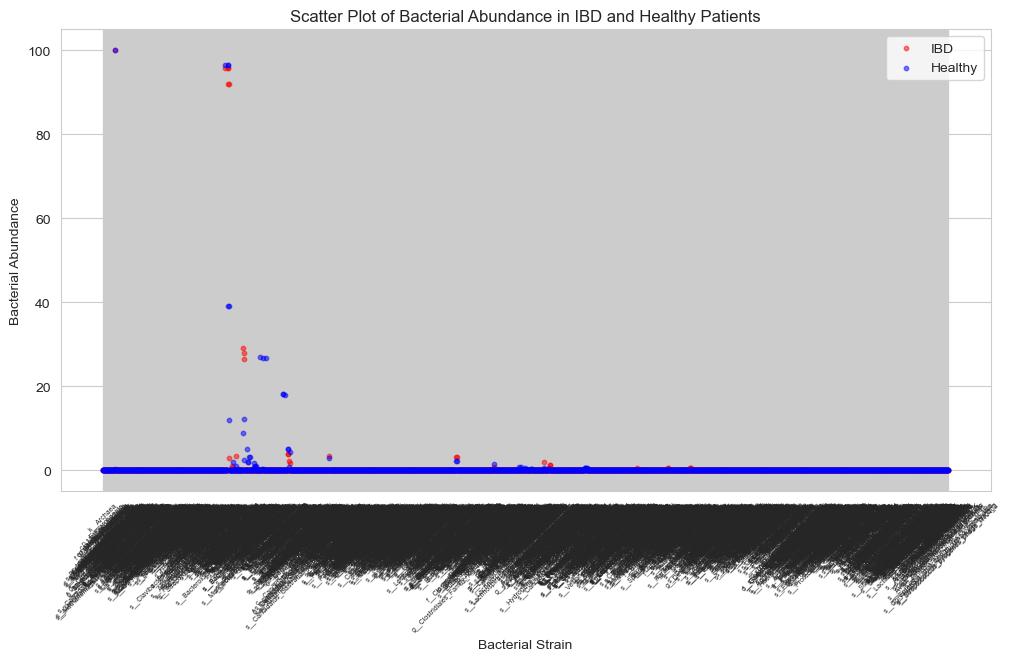

In [228]:
# 繪製散點圖
plt.figure(figsize=(12, 6), facecolor='white')

# 繪製散點圖
# 將 IBD_bacteria 和 healthy_bacteria 轉置後取第二個維度
# 健康跟病患各以第十個數據作圖
plt.scatter(simplified_strain_names, IBD_bacteria.T[:, 9], alpha=0.5, label='IBD', c='red', s=10)
plt.scatter(simplified_strain_names, healthy_bacteria.T[:, 9], alpha=0.5, label='Healthy', c='blue', s=10)

# 設定標籤、標題、圖例等
plt.xlabel('Bacterial Strain')
plt.ylabel('Bacterial Abundance')
plt.xticks(rotation=45, fontsize=5)
plt.title('Scatter Plot of Bacterial Abundance in IBD and Healthy Patients')
plt.legend()

# 顯示圖形
plt.show()

## 3. 找出造成 IBD 的特徵菌株, 預測易造成發炎症狀的菌相分佈
##### 隨機森林分類法

In [164]:
# 將健康和 IBD 患者的菌株數據合併成一個數據集
X = np.vstack((healthy_bacteria, IBD_bacteria))

# 依健康和 IBD 患者的數量建一組 array, 將健康設為 0, IBD 患者設為 1 
y = np.hstack((np.zeros(healthy_bacteria.shape[0]), np.ones(IBD_bacteria.shape[0])))

In [169]:
y.shape

(15040,)

In [170]:
X.shape

(15040, 2559)

In [171]:
# 以 7:3 分割數據集為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [178]:
X_train.shape

(10528, 2559)

In [180]:
X_train

array([[0.639688, 0.639688, 0.639688, ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [1.874888, 1.874888, 1.874888, ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.944963, 0.944963, 0.944963, ..., 0.      , 0.      , 0.      ],
       [0.631872, 0.631872, 0.631872, ..., 0.      , 0.      , 0.      ]])

In [220]:
y_train.shape

(10528,)

In [221]:
y_train

array([0., 0., 0., ..., 0., 0., 0.])

Top 10 features and their importance scores:
1. f__Eggerthellaceae (0.013787)
2. s__Bacteroides_vulgatus (0.010920)
3. c__Bacilli (0.010488)
4. s__Gemmiger_formicilis (0.009929)
5. o__Eggerthellales (0.009297)
6. p__Actinobacteria (0.009170)
7. f__Bacteroidaceae (0.009104)
8. g__Gemmiger (0.008597)
9. g__Flavonifractor (0.008515)
10. g__Lachnoclostridium (0.008270)


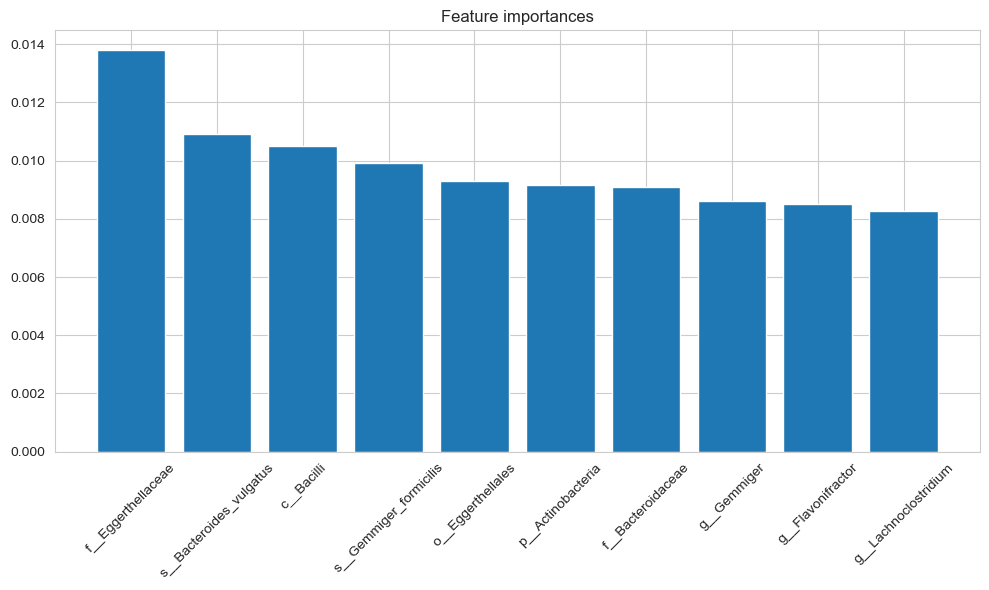

In [246]:
# 創建隨機森林分類器並擬合訓練集
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# 使用 feature_importances_ 屬性找出特徵重要性
importances = rfc.feature_importances_

# 根據特徵重要性從高到低排序
indices = np.argsort(importances)[::-1]

# 印出前 10 個特徵及其重要性分數
print("Top 10 features and their importance scores:")
for f in range(10):
    print("%d. %s (%f)" % (f + 1, simplified_strain_names[indices[f]], importances[indices[f]]))

# 將 simplified_strain_names 轉換為 array
simplified_strain_names = np.array(simplified_strain_names)

# 繪製前 10 個特徵的重要性分數長條圖
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(10), importances[indices[:10]])
plt.xticks(range(10), simplified_strain_names[indices[:10]], rotation=45)
plt.tight_layout()
plt.show()

In [262]:
accuracy_test = rfc.score(X_test, y_test)
print("Accuracy of testing data: %f" % accuracy_test)

Accuracy of testing data: 0.927527


In [263]:
accuracy_train = rfc.score(X_train, y_train)
print("Accuracy of training data: %f" % accuracy_train)

Accuracy of training data: 1.000000


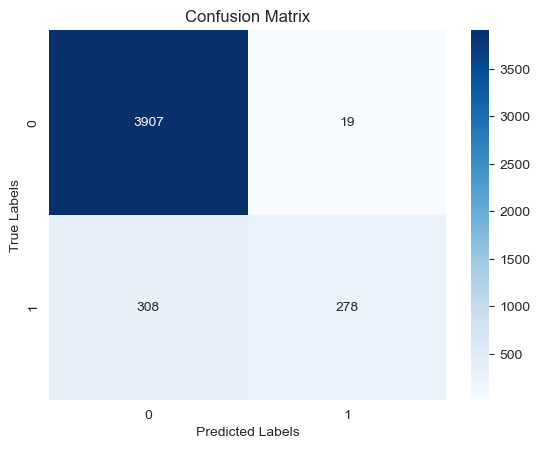

In [251]:
# 得到測試集上的預測結果
y_pred = rfc.predict(X_test)

# 計算混淆矩陣
cm = confusion_matrix(y_test, y_pred)

# 繪製混淆矩陣熱力圖
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [254]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision: %f" % precision)
print("Recall: %f" % recall)
print("F1 Score: %f" % f1)

Precision: 0.928109
Recall: 0.927527
F1 Score: 0.916953


##### SVM分類法

In [256]:
# 創建 SVM 分類器並訓練
svc = SVC(kernel='rbf', C=10, gamma=0.1, random_state=42)
svc.fit(X_train, y_train)

SVC(C=10, gamma=0.1, random_state=42)

In [264]:
# 在測試集上評估 SVM 分類器的性能
svc_score_test = svc.score(X_test, y_test)
print("SVM Accuracy of testing data: %f" % svc_score_test)

SVM Accuracy of testing data: 0.870124


In [265]:
svc_score = svc.score(X_train, y_train)
print("SVM Accuracy: %f" % svc_score)

SVM Accuracy: 1.000000


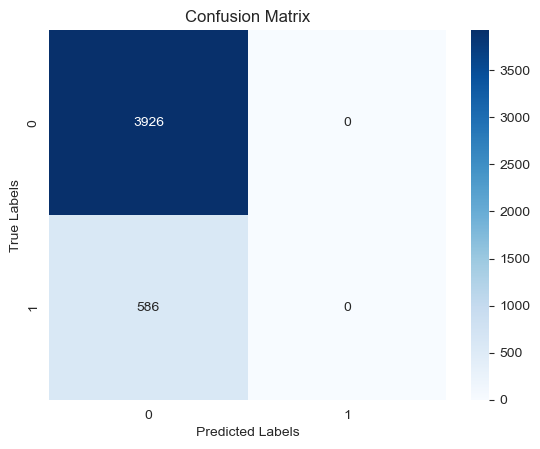

In [259]:
# 計算混淆矩陣並繪製熱力圖
y_pred = svc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [260]:
# 計算精確度、召回率和 F1 值
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision: %f" % precision)
print("Recall: %f" % recall)
print("F1 Score: %f" % f1)

Precision: 0.757116
Recall: 0.870124
F1 Score: 0.809696


##### 先用方差門檻篩選特徵值, 再用 SVM

In [285]:
# 使用方差門檻篩選特徵值
selector = VarianceThreshold(threshold=400)
X_train_select = selector.fit_transform(X_train)
X_test_select = selector.transform(X_test)

In [286]:
X_train_select.shape

(10528, 9)

In [288]:
# 共 482 個特徵被選中, 看前十個和方差值
variances = selector.variances_
selected_features = selector.get_support()
selected_feature_names = [simplified_strain_names[i] for i in range(len(simplified_strain_names)) if selected_features[i]]
selected_variances = [variances[i] for i in range(len(variances)) if selected_features[i]]

print('Selected feature names and variances:')
for i in range(9):
    print(selected_feature_names[i], selected_variances[i])

Selected feature names and variances:
p__Actinobacteria 404.206971751196
p__Bacteroidetes 796.3177589329846
c__Bacteroidia 796.33178035624
o__Bacteroidales 796.33178035624
f__Bacteroidaceae 574.8944627796227
g__Bacteroides 574.8953104060531
p__Firmicutes 545.2589630499668
c__Clostridia 499.7059732057371
o__Clostridiales 499.7059732057371


In [293]:
# 創建SVM模型並訓練
svm = SVC(kernel='rbf', C=10, gamma=0.1, random_state=42)
svm.fit(X_train_select, y_train)

SVC(C=10, gamma=0.1, random_state=42)

In [294]:
# 計算訓練集的準確率
train_accuracy = svm.score(X_train_select, y_train)
print(f'Training accuracy: {train_accuracy:.4f}')

Training accuracy: 0.9934


In [295]:
# 計算測試集的準確率
test_accuracy = svm.score(X_test_select, y_test)
print(f'Testing accuracy: {test_accuracy:.4f}')

Testing accuracy: 0.8464
